# Importing necessary things

In [1]:
import pandas as pd
import numpy as np
import sklearn

import sklearn.metrics as metrics
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, RegexpTokenizer, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

from collections import Counter

import re
from datetime import datetime

import pickle

import string

==================================================================================================================

# Retrieving lists and making Dataframes

In [2]:
# Retrieving the lists.

import bz2

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = pickle.load(data)
    return data

In [3]:
# Seeing if everything transferred properly

reviewlistglobal = decompress_pickle('compressedlistreview.pbz2')
reviewlistsea = decompress_pickle('compressedlistreview2.pbz2')
reviewlistapple = decompress_pickle('compressedlistreviewapple.pbz2')

print(len(reviewlistglobal))
print(len(reviewlistsea))
print(len(reviewlistapple))

6470
72164
2568


In [4]:
dfglobal = pd.DataFrame(reviewlistglobal)
dfglobal.head()

,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,appId
0,Not permitted,1,0,None,2020-12-20 10:14:08,None,com.gravity.romNAg
1,years of playing on pc and this version came o...,5,0,1.2.6,2020-12-19 06:12:56,None,com.gravity.romNAg
2,"P2W till the end, prices are way too high... A...",1,0,None,2020-12-17 05:01:06,None,com.gravity.romNAg
3,Great game a Lots fun,5,0,1.2.6,2020-12-17 01:38:27,None,com.gravity.romNAg
4,I love Eternal Love,5,0,1.2.6,2020-12-12 23:30:19,None,com.gravity.romNAg


In [5]:
dfsea = pd.DataFrame(reviewlistsea)
dfsea.head()

,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,appId
0,This is a suggestion from one of the known str...,5,0,1.0.33,2020-12-20 10:36:00,None,com.gravity.romg
1,new update made several freezing screen. can't...,1,0,1.0.35,2020-12-20 10:12:36,None,com.gravity.romg
2,Very Happy,5,0,None,2020-12-20 09:40:34,None,com.gravity.romg
3,Lag delay,1,0,1.0.35,2020-12-20 07:18:42,None,com.gravity.romg
4,Laggy,2,0,1.0.35,2020-12-20 06:50:06,None,com.gravity.romg


In [6]:
dfapple = pd.DataFrame(reviewlistapple)
dfapple.head()

,date,review,userName,isEdited,title,rating
0,2020-02-25 02:00:45,I played Ragnarok Online for over a decade sta...,Don-Karnage,False,The best version of Ragnarok on mobile,5
1,2020-06-22 07:12:05,"Full disclosure, I’ve played this game since l...",SexGodCrusher,False,"A fantastic MMORPG, but with its fair share of...",4
2,2019-11-26 06:35:01,This game could be amazing. I love it and don’...,Kwestland,False,I love this game but developers ignore complaints,4
3,2019-10-25 23:14:50,"As you would know if you read the title, I’m a...",lindaxw,False,"I am not being paid, nor am I a robot",5
4,2020-11-27 01:30:44,First I’d like to point out your own website p...,PatfromPittsburgh,False,Update broke the game,1


# Changing datatypes to correct datatypes.

In [8]:
#Changing datatype to correct datatype as they are all objects.

print(dfglobal.dtypes)
print('----------------')
print(dfsea.dtypes)
print('----------------')
print(dfapple.dtypes)

content                 object
score                   object
thumbsUpCount           object
reviewCreatedVersion    object
at                      object
replyContent            object
appId                   object
dtype: object
----------------
content                 object
score                   object
thumbsUpCount           object
reviewCreatedVersion    object
at                      object
replyContent            object
appId                   object
dtype: object
----------------
date        datetime64[ns]
review              object
userName            object
isEdited              bool
title               object
rating               int64
dtype: object


In [17]:
dfglobal['content'] = dfglobal['content'].astype('string')
dfglobal['score'] = dfglobal['score'].astype('int')
dfglobal['thumbsUpCount'] = dfglobal['thumbsUpCount'].astype('int')
dfglobal['reviewCreatedVersion'] = dfglobal['reviewCreatedVersion'].astype('string')
dfglobal['at'] = dfglobal['at'].astype('string')
dfglobal['replyContent'] = dfglobal['replyContent'].astype('string')
dfglobal['appId'] = dfglobal['appId'].astype('string')

################################################

dfsea['content'] = dfsea['content'].astype('string')
dfsea['score'] = dfsea['score'].astype('int')
dfsea['thumbsUpCount'] = dfsea['thumbsUpCount'].astype('int')
dfsea['reviewCreatedVersion'] = dfsea['reviewCreatedVersion'].astype('string')
dfsea['at'] = dfsea['at'].astype('string')
dfsea['replyContent'] = dfsea['replyContent'].astype('string')
dfsea['appId'] = dfsea['appId'].astype('string')

################################################

dfapple['date'] = dfapple['date'].astype('string')
dfapple['review'] = dfapple['review'].astype('string')

In [10]:
# checking for null values.

print(dfglobal.isna().sum())
print('-------------------------')
print(dfsea.isna().sum())
print('-------------------------')
print(dfapple.isna().sum())

content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
replyContent            0
appId                   0
dtype: int64
-------------------------
content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
replyContent            0
appId                   0
dtype: int64
-------------------------
date        0
review      0
userName    0
isEdited    0
title       0
rating      0
dtype: int64


==================================================================================================================

# EDA

In [12]:
# Looking at distribution of ratings in both global and sea

print(dfglobal['score'].value_counts())
print('---------------------')
print(dfsea['score'].value_counts())
print('---------------------')
print(dfapple['rating'].value_counts())

5    3082
1    1767
4     649
3     565
2     407
Name: score, dtype: int64
---------------------
5    33320
1    27520
4     4865
3     3843
2     2616
Name: score, dtype: int64
---------------------
1    1088
5     803
3     253
2     224
4     200
Name: rating, dtype: int64


In [14]:
scorecountglobal = Counter(dfglobal['score'])
scorecountsea = Counter(dfsea['score'])
scorecountapple = Counter(dfapple['rating'])

print(scorecountglobal.most_common(5))
print('-----------------------------------------')
print(scorecountsea.most_common(5))
print('-----------------------------------------')
print(scorecountapple.most_common(5))

[(5, 3082), (1, 1767), (4, 649), (3, 565), (2, 407)]
-----------------------------------------
[(5, 33320), (1, 27520), (4, 4865), (3, 3843), (2, 2616)]
-----------------------------------------
[(1, 1088), (5, 803), (3, 253), (2, 224), (4, 200)]


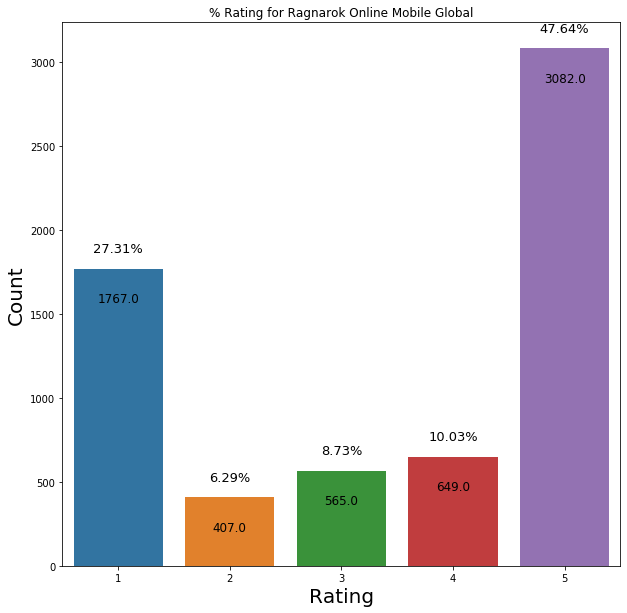

In [15]:
# Plotting distribution of ratings out of all the reviews
# Interestingly, it is very similar to overall rating distribution across all top mobile games.


xaxis = [val[0] for val in scorecountglobal.most_common(5)]
yaxis = [val[1] for val in scorecountglobal.most_common(5)]

plt.figure(figsize=(10,10))
ax = sns.barplot(xaxis, yaxis)

plt.title('% Rating for Ragnarok Online Mobile Global')
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Rating', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')
        
for p in ax.patches:
             ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, -30),
                 textcoords='offset points')

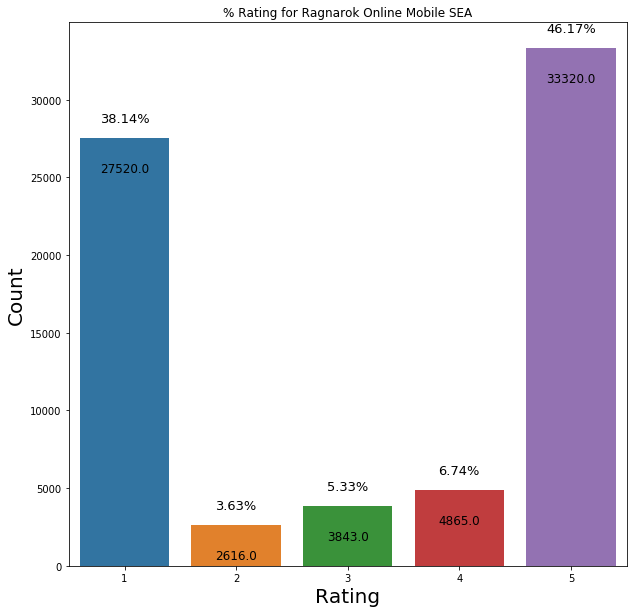

In [14]:
xaxis = [val[0] for val in scorecountsea.most_common(5)]
yaxis = [val[1] for val in scorecountsea.most_common(5)]

plt.figure(figsize=(10,10))
ax = sns.barplot(xaxis, yaxis)

plt.title('% Rating for Ragnarok Online Mobile SEA')
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Rating', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')
        
for p in ax.patches:
             ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, -30),
                 textcoords='offset points')

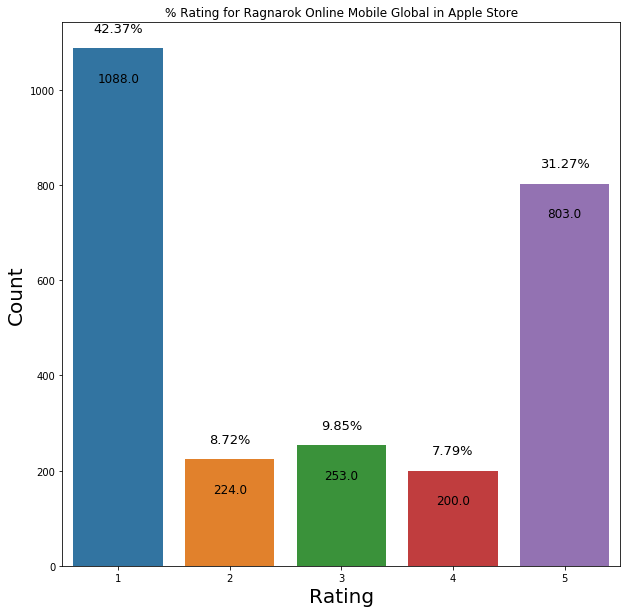

In [15]:
xaxis = [val[0] for val in scorecountapple.most_common(5)]
yaxis = [val[1] for val in scorecountapple.most_common(5)]

plt.figure(figsize=(10,10))
ax = sns.barplot(xaxis, yaxis)

plt.title('% Rating for Ragnarok Online Mobile Global in Apple Store')
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Rating', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')
        
for p in ax.patches:
             ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, -30),
                 textcoords='offset points')

In [20]:
# Interestingly despite following the same-ish timeline and being on the same page,
# the listed reviews created versions are different.

print(dfglobal['reviewCreatedVersion'].value_counts())
print('---------------------')
print(dfsea['reviewCreatedVersion'].value_counts())

1.0.1    4427
None     1177
1.0.7     216
1.1.3     147
1.0.5     147
1.1.0     133
1.2.0      74
1.2.2      60
1.2.4      51
1.2.6      38
Name: reviewCreatedVersion, dtype: Int64
---------------------
1.0.5     25375
None      13880
1.0.9     11780
1.0.8     11227
1.0.25     2393
1.0.27     2139
1.0.10     1751
1.0.33     1502
1.0.30     1004
1.0.35      656
1.0.3       455
1.0.32        2
Name: reviewCreatedVersion, dtype: Int64


### Datetime cleaning

In [18]:
dfglobal['at'] = dfglobal['at'].str[0:10]
dfsea['at'] = dfsea['at'].str[0:10]
dfapple['date'] = dfapple['date'].str[0:10]

print(dfglobal['at'].value_counts())
print('---------------------')
print(dfsea['at'].value_counts())
print('---------------------')
print(dfapple['date'].value_counts())

2019-01-09    715
2019-01-10    408
2019-01-11    264
2019-01-12    197
2019-01-08    167
             ... 
2020-11-30      1
2020-08-15      1
2019-10-26      1
2020-05-13      1
2020-03-19      1
Name: at, Length: 618, dtype: Int64
---------------------
2018-10-31    6034
2018-11-01    2683
2019-01-14    2528
2018-10-30    2195
2019-07-28    2050
              ... 
2020-11-21       9
2020-12-17       8
2020-11-18       8
2020-12-16       7
2020-09-21       6
Name: at, Length: 783, dtype: Int64
---------------------
2019-01-09    309
2019-01-10    170
2019-01-08    126
2019-01-11    109
2019-01-12     89
             ... 
2020-07-11      1
2020-04-26      1
2019-04-13      1
2019-07-25      1
2019-06-17      1
Name: date, Length: 509, dtype: Int64


In [19]:
dfglobal['month'] = dfglobal['at'].str[5:7]
dfsea['month'] = dfsea['at'].str[5:7]
dfapple['month'] = dfapple['date'].str[5:7]

In [20]:
dfglobal['at'] = pd.to_datetime(dfglobal['at'], format='%Y-%m-%d')
dfsea['at'] = pd.to_datetime(dfsea['at'], format='%Y-%m-%d')
dfapple['date'] = pd.to_datetime(dfapple['date'], format='%Y-%m-%d')

In [28]:
reviewglobaltimecounts = dfglobal['at'].value_counts().reset_index(name='counts')
reviewglobaltimecounts.columns = ['date', 'counts']

reviewseatimecounts = dfsea['at'].value_counts().reset_index(name='counts')
reviewseatimecounts.columns = ['date', 'counts']

print(reviewglobaltimecounts)
print('----------------------')
print(reviewseatimecounts)

          date  counts
0   2019-01-09     715
1   2019-01-10     408
2   2019-01-11     264
3   2019-01-12     197
4   2019-01-08     167
..         ...     ...
613 2019-07-17       1
614 2019-11-26       1
615 2020-02-13       1
616 2020-05-04       1
617 2020-11-30       1

[618 rows x 2 columns]
----------------------
          date  counts
0   2018-10-31    6034
1   2018-11-01    2683
2   2019-01-14    2528
3   2018-10-30    2195
4   2019-07-28    2050
..         ...     ...
778 2020-11-22       9
779 2020-11-18       8
780 2020-12-17       8
781 2020-12-16       7
782 2020-09-21       6

[783 rows x 2 columns]


In [29]:
reviewglobaltimecounts = reviewglobaltimecounts.sort_values(by='date')
reviewseatimecounts = reviewseatimecounts.sort_values(by='date')

reviewglobalmonthcount = dfglobal['month'].value_counts().reset_index(name='counts')
reviewglobalmonthcount.columns = ['month', 'counts']

reviewseamonthcount = dfsea['month'].value_counts().reset_index(name='counts')
reviewseamonthcount.columns = ['month', 'counts']

print(reviewglobalmonthcount)
print('----------------------')
print(reviewseamonthcount)

   month  counts
0     01    3293
1     02     770
2     03     629
3     04     492
4     05     268
5     06     224
6     07     164
7     09     161
8     08     157
9     10     132
10    11     115
11    12      65
----------------------
   month  counts
0     11   18645
1     10   10687
2     01   10052
3     12    7662
4     07    6648
5     08    5313
6     02    3019
7     03    2643
8     04    2178
9     09    1982
10    06    1745
11    05    1590


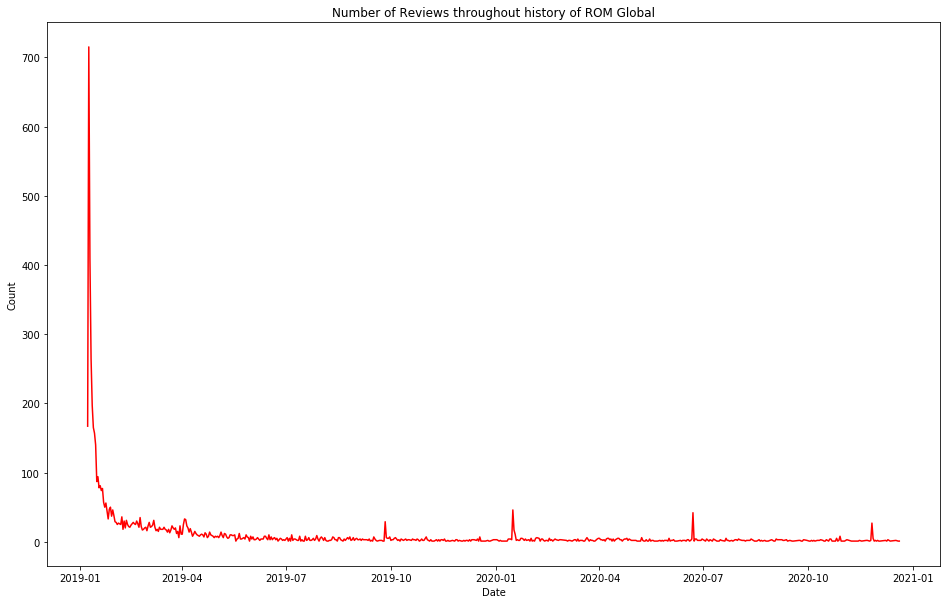

In [30]:
fig, ax = plt.subplots(figsize=(16, 10))

ax.plot(reviewglobaltimecounts['date'],
        reviewglobaltimecounts['counts'],
        color='red')

ax.set(xlabel="Date",
       ylabel="Count",
       title="Number of Reviews throughout history of ROM Global")

plt.show()

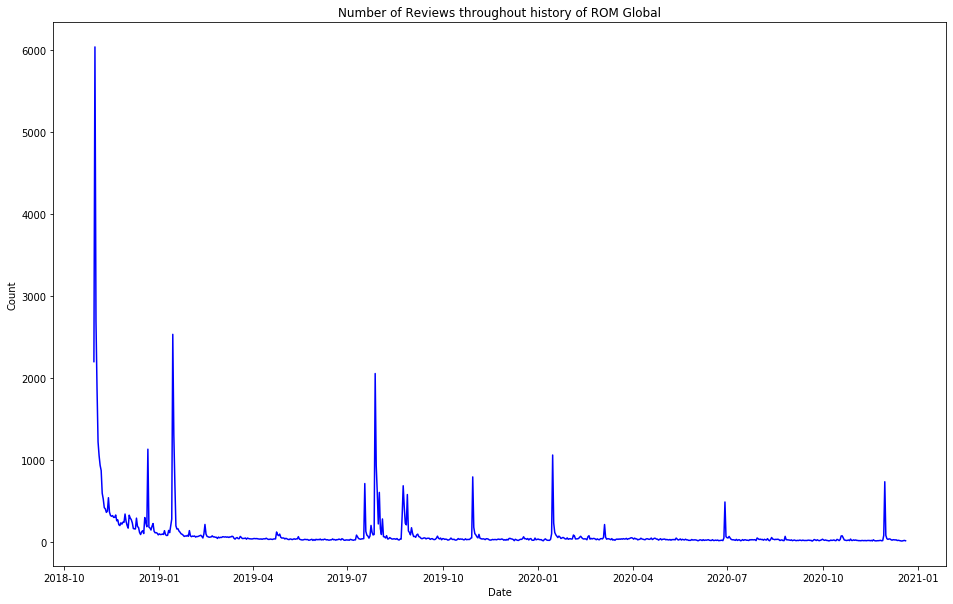

In [31]:
fig, ax = plt.subplots(figsize=(16, 10))

ax.plot(reviewseatimecounts['date'],
        reviewseatimecounts['counts'],
        color='blue')

ax.set(xlabel="Date",
       ylabel="Count",
       title="Number of Reviews throughout history of ROM Global")

plt.show()

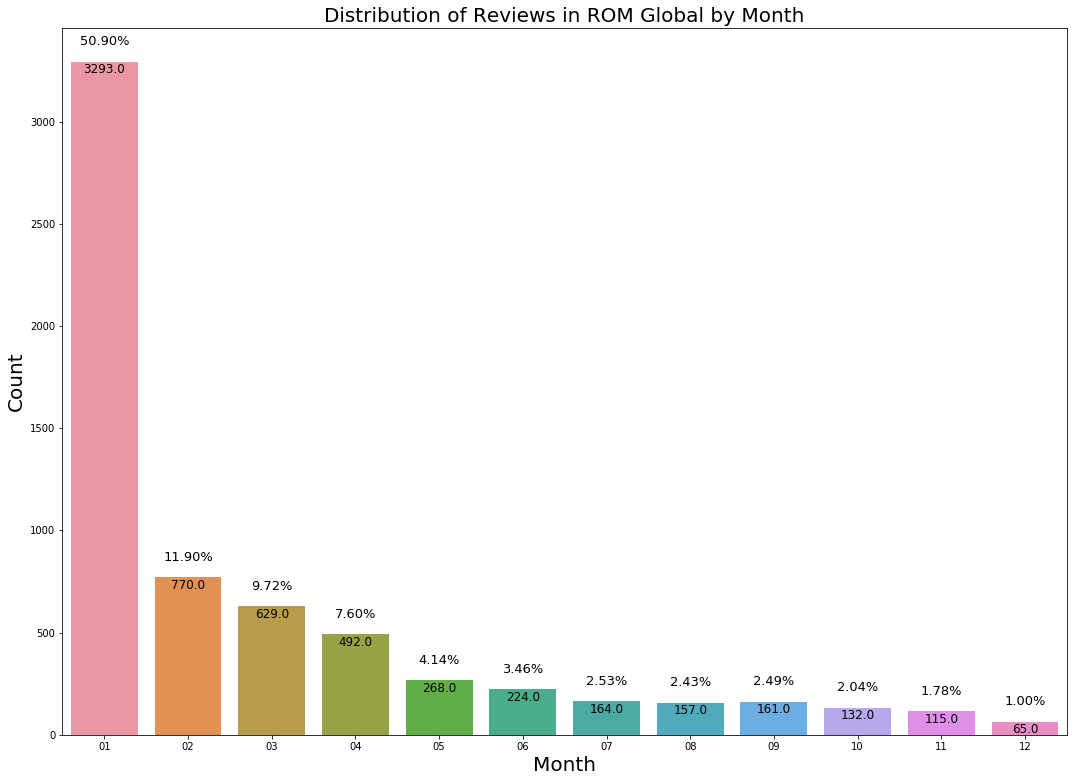

In [32]:
plt.figure(figsize=(18,13))
ax = sns.barplot(reviewglobalmonthcount['month'], reviewglobalmonthcount['counts'])

plt.title('Distribution of Reviews in ROM Global by Month', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Month', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(reviewglobalmonthcount['counts']))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')
        
for p in ax.patches:
             ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, -8),
                 textcoords='offset points')

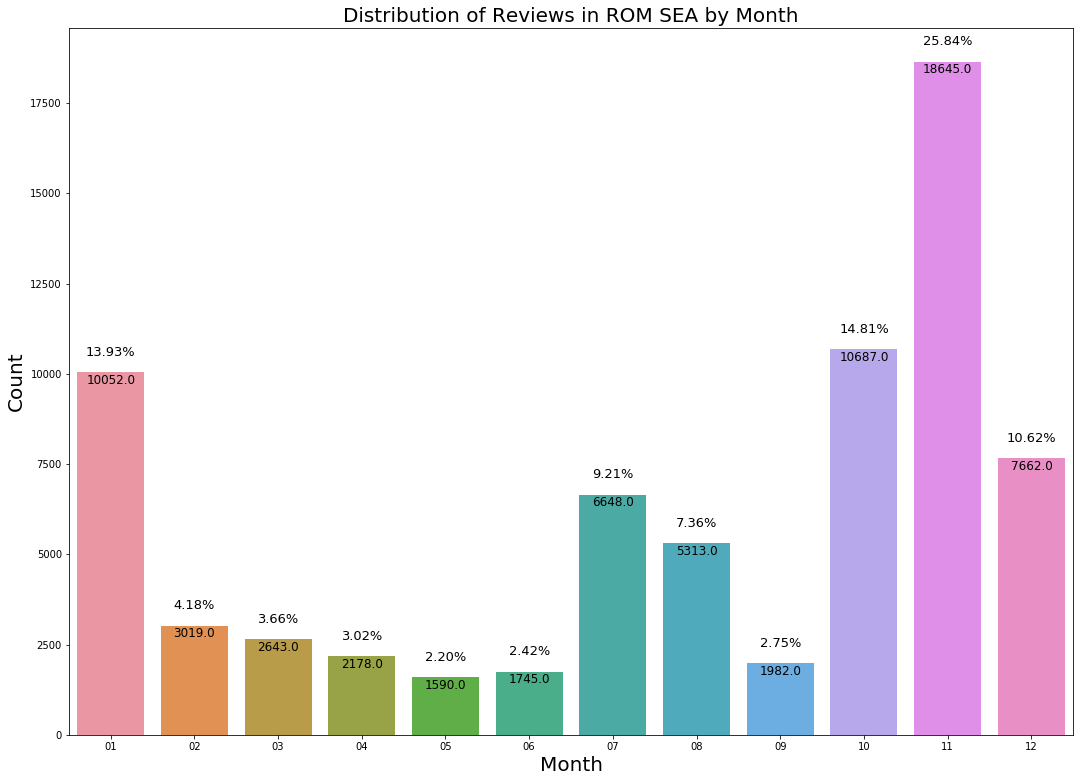

In [33]:
plt.figure(figsize=(18,13))
ax = sns.barplot(reviewseamonthcount['month'], reviewseamonthcount['counts'])

plt.title('Distribution of Reviews in ROM SEA by Month', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Month', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(reviewseamonthcount['counts']))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')
        
for p in ax.patches:
             ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', xytext=(0, -8),
                 textcoords='offset points')

## Meta Features

In [21]:
print(dfglobal['content'])
print('----------------------------------------------------------')
print(dfsea['content'])
print('----------------------------------------------------------')
print(dfapple['review'])

0                                           Not permitted
1       years of playing on pc and this version came o...
2       P2W till the end, prices are way too high... A...
3                                   Great game a Lots fun
4                                     I love Eternal Love
                              ...                        
6465       the best gaming experience for a mobile mmorpg
6466                                  nice game, pls dont
6467    it let me download and install but will not le...
6468    Gravity❤❤❤ R.O.Mobile version 😍😍😍! So, excitin...
6469    I love the old game can't wait to fall in love...
Name: content, Length: 6470, dtype: string
----------------------------------------------------------
0        This is a suggestion from one of the known str...
1        new update made several freezing screen. can't...
2                                               Very Happy
3                                                Lag delay
4                       

## Meta Features for ROM Global

In [39]:
dfglobal["numwords"] = dfglobal["content"].apply(lambda x: len(str(x).split()))

dfglobal["numuniquewords"] = dfglobal["content"].apply(lambda x: len(set(str(x).split())))

dfglobal["numchars"] = dfglobal["content"].apply(lambda x: len(str(x)))

dfglobal["numpuncts"] = dfglobal['content'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

dfglobal["numcapts"] = dfglobal["content"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

dfglobal["numtitles"] = dfglobal["content"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

dfglobal["meanwordlength"] = dfglobal["content"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


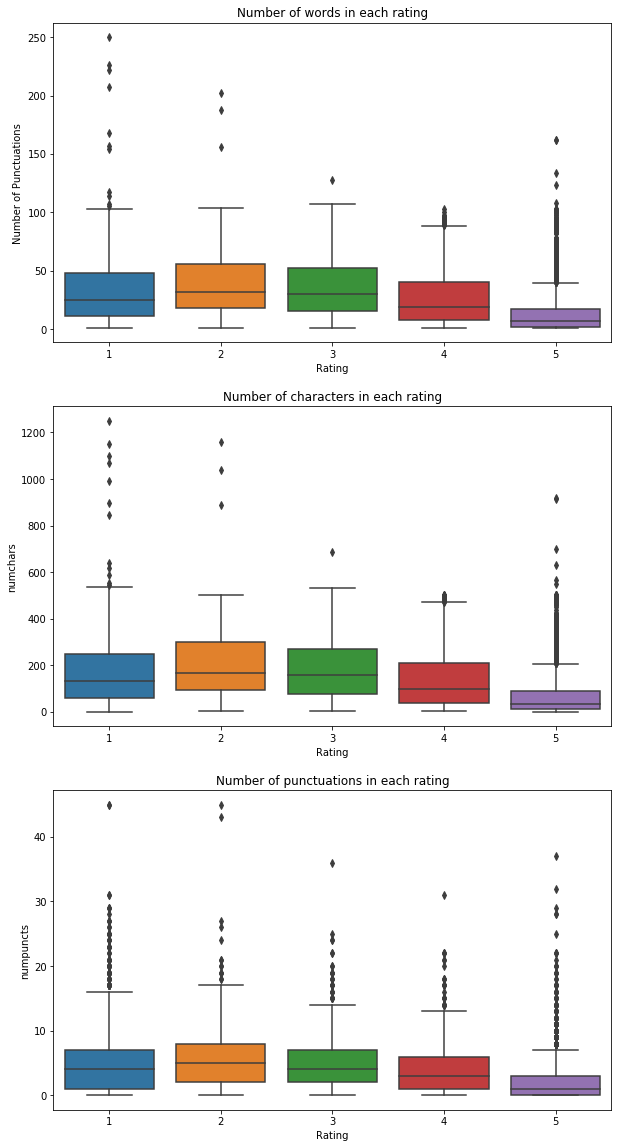

In [40]:
## Truncate some extreme values for better visuals ##
dfglobal['numwords'].loc[dfglobal['numwords']>250] = 250 
dfglobal['numchars'].loc[dfglobal['numchars']>1250] = 1250
dfglobal['numpuncts'].loc[dfglobal['numpuncts']>45] = 45

f, axes = plt.subplots(3, 1, figsize=(10,20))

sns.boxplot(x='score', y='numwords', data=dfglobal, ax=axes[0])
axes[0].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Words', fontsize=10)
axes[0].set_title("Number of words in each rating", fontsize=12)

sns.boxplot(x='score', y='numchars', data=dfglobal, ax=axes[1])
axes[1].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Characters', fontsize=10)
axes[1].set_title("Number of characters in each rating", fontsize=12)

sns.boxplot(x='score', y='numpuncts', data=dfglobal, ax=axes[2])
axes[2].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Punctuations', fontsize=10)
axes[2].set_title("Number of punctuations in each rating", fontsize=12)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


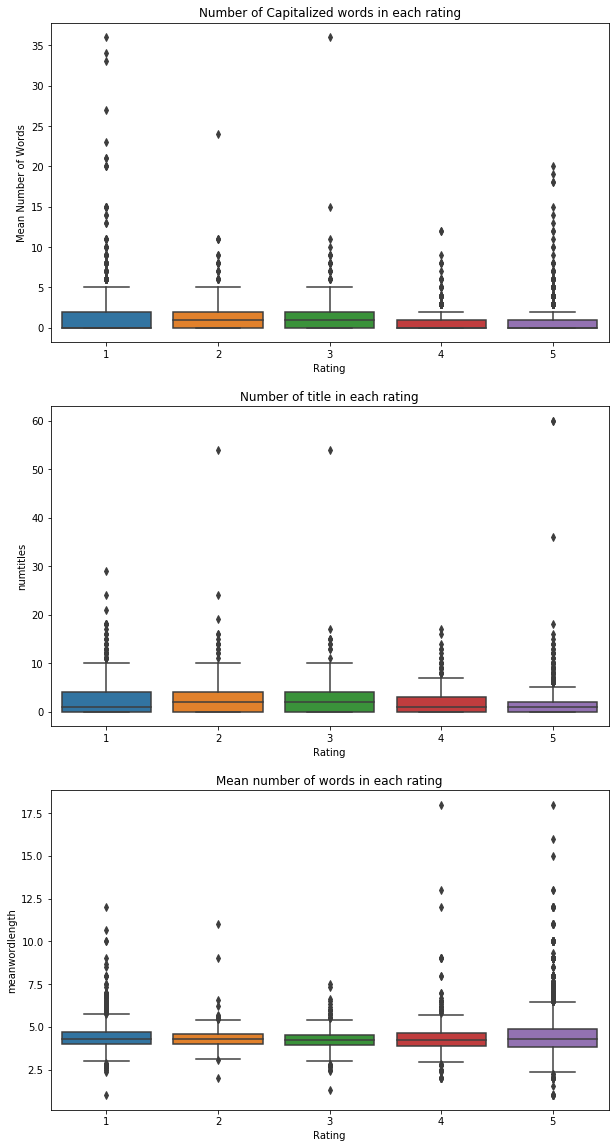

In [41]:
dfglobal['numcapts'].loc[dfglobal['numcapts']>36] = 36 
dfglobal['numtitles'].loc[dfglobal['numtitles']>60] = 60
dfglobal['meanwordlength'].loc[dfglobal['meanwordlength']>18] = 18

f, axes = plt.subplots(3, 1, figsize=(10,20))

sns.boxplot(x='score', y='numcapts', data=dfglobal, ax=axes[0])
axes[0].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Capitalized Words', fontsize=10)
axes[0].set_title("Number of Capitalized words in each rating", fontsize=12)

sns.boxplot(x='score', y='numtitles', data=dfglobal, ax=axes[1])
axes[1].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Title Characters', fontsize=10)
axes[1].set_title("Number of title in each rating", fontsize=12)

sns.boxplot(x='score', y='meanwordlength', data=dfglobal, ax=axes[2])
axes[2].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Mean Number of Words', fontsize=10)
axes[2].set_title("Mean number of words in each rating", fontsize=12)
plt.show()

## Meta Features for ROM Sea

In [42]:
dfsea["numwords"] = dfsea["content"].apply(lambda x: len(str(x).split()))

dfsea["numuniquewords"] = dfsea["content"].apply(lambda x: len(set(str(x).split())))

dfsea["numchars"] = dfsea["content"].apply(lambda x: len(str(x)))

dfsea["numpuncts"] = dfsea['content'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

dfsea["numcapts"] = dfsea["content"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

dfsea["numtitles"] = dfsea["content"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

dfsea["meanwordlength"] = dfsea["content"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


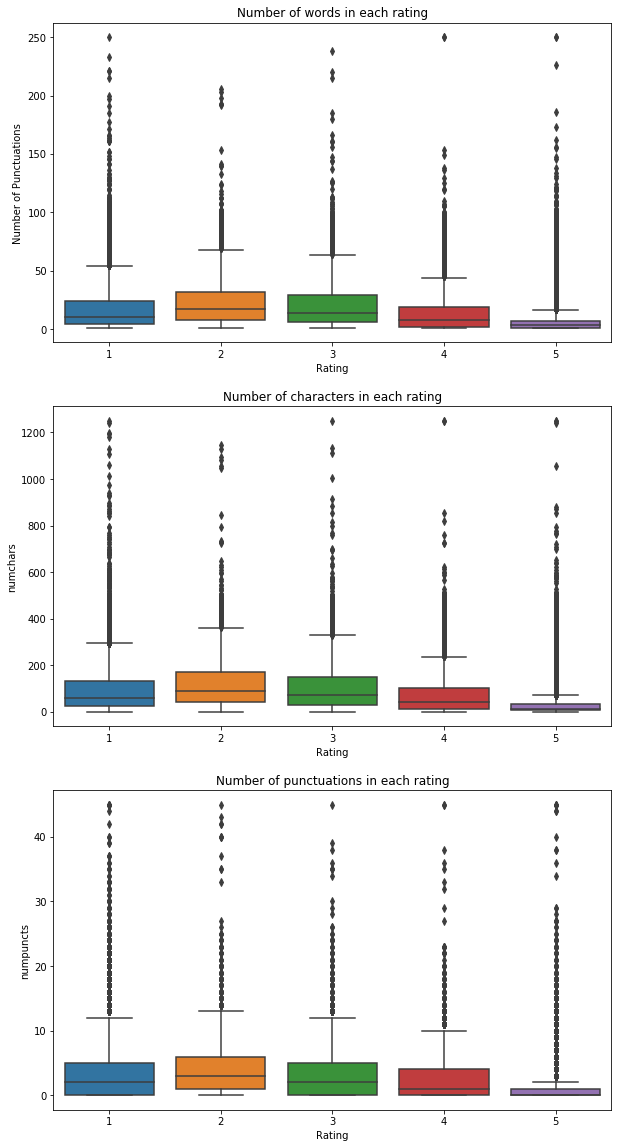

In [43]:
## Truncate some extreme values for better visuals ##
dfsea['numwords'].loc[dfsea['numwords']>250] = 250 
dfsea['numchars'].loc[dfsea['numchars']>1250] = 1250
dfsea['numpuncts'].loc[dfsea['numpuncts']>45] = 45

f, axes = plt.subplots(3, 1, figsize=(10,20))

sns.boxplot(x='score', y='numwords', data=dfsea, ax=axes[0])
axes[0].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Words', fontsize=10)
axes[0].set_title("Number of words in each rating", fontsize=12)

sns.boxplot(x='score', y='numchars', data=dfsea, ax=axes[1])
axes[1].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Characters', fontsize=10)
axes[1].set_title("Number of characters in each rating", fontsize=12)

sns.boxplot(x='score', y='numpuncts', data=dfsea, ax=axes[2])
axes[2].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Punctuations', fontsize=10)
axes[2].set_title("Number of punctuations in each rating", fontsize=12)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


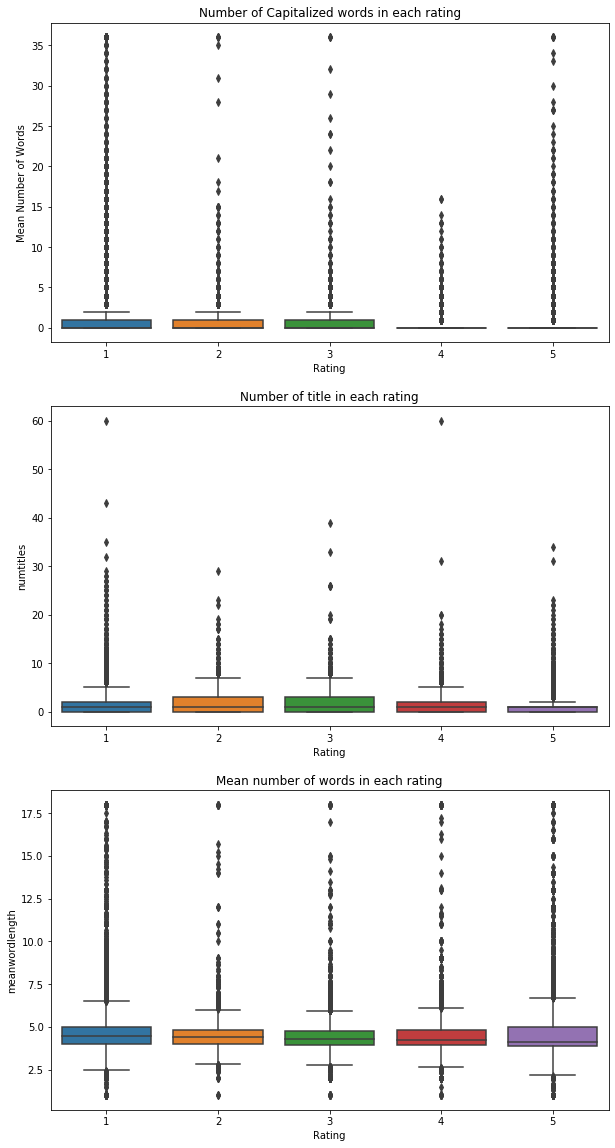

In [44]:
dfsea['numcapts'].loc[dfsea['numcapts']>36] = 36 
dfsea['numtitles'].loc[dfsea['numtitles']>60] = 60
dfsea['meanwordlength'].loc[dfsea['meanwordlength']>18] = 18

f, axes = plt.subplots(3, 1, figsize=(10,20))

sns.boxplot(x='score', y='numcapts', data=dfsea, ax=axes[0])
axes[0].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Capitalized Words', fontsize=10)
axes[0].set_title("Number of Capitalized words in each rating", fontsize=12)

sns.boxplot(x='score', y='numtitles', data=dfsea, ax=axes[1])
axes[1].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Title Characters', fontsize=10)
axes[1].set_title("Number of title in each rating", fontsize=12)

sns.boxplot(x='score', y='meanwordlength', data=dfsea, ax=axes[2])
axes[2].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Mean Number of Words', fontsize=10)
axes[2].set_title("Mean number of words in each rating", fontsize=12)
plt.show()

## Meta Features for Ragnarok Mobile Global on Apple Store

In [23]:
dfapple["numwords"] = dfapple["review"].apply(lambda x: len(str(x).split()))

dfapple["numuniquewords"] = dfapple["review"].apply(lambda x: len(set(str(x).split())))

dfapple["numchars"] = dfapple["review"].apply(lambda x: len(str(x)))

dfapple["numpuncts"] = dfapple['review'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

dfapple["numcapts"] = dfapple["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

dfapple["numtitles"] = dfapple["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

dfapple["meanwordlength"] = dfapple["review"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

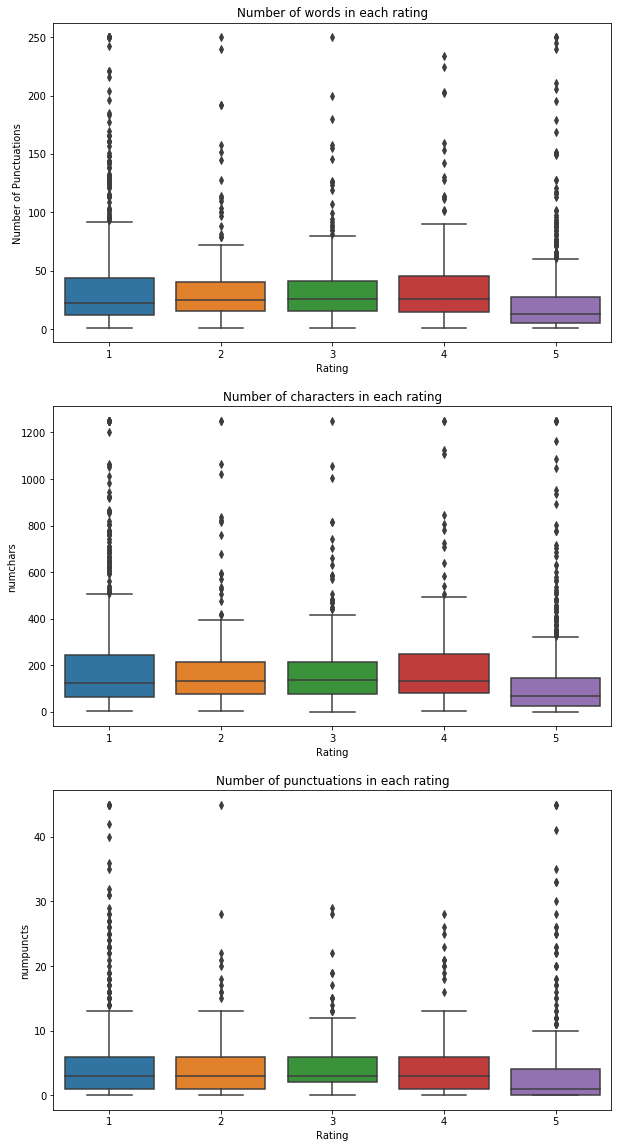

In [25]:
## Truncate some extreme values for better visuals ##
dfapple['numwords'].loc[dfapple['numwords']>250] = 250 
dfapple['numchars'].loc[dfapple['numchars']>1250] = 1250
dfapple['numpuncts'].loc[dfapple['numpuncts']>45] = 45

f, axes = plt.subplots(3, 1, figsize=(10,20))

sns.boxplot(x='rating', y='numwords', data=dfapple, ax=axes[0])
axes[0].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Words', fontsize=10)
axes[0].set_title("Number of words in each rating", fontsize=12)

sns.boxplot(x='rating', y='numchars', data=dfapple, ax=axes[1])
axes[1].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Characters', fontsize=10)
axes[1].set_title("Number of characters in each rating", fontsize=12)

sns.boxplot(x='rating', y='numpuncts', data=dfapple, ax=axes[2])
axes[2].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Punctuations', fontsize=10)
axes[2].set_title("Number of punctuations in each rating", fontsize=12)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


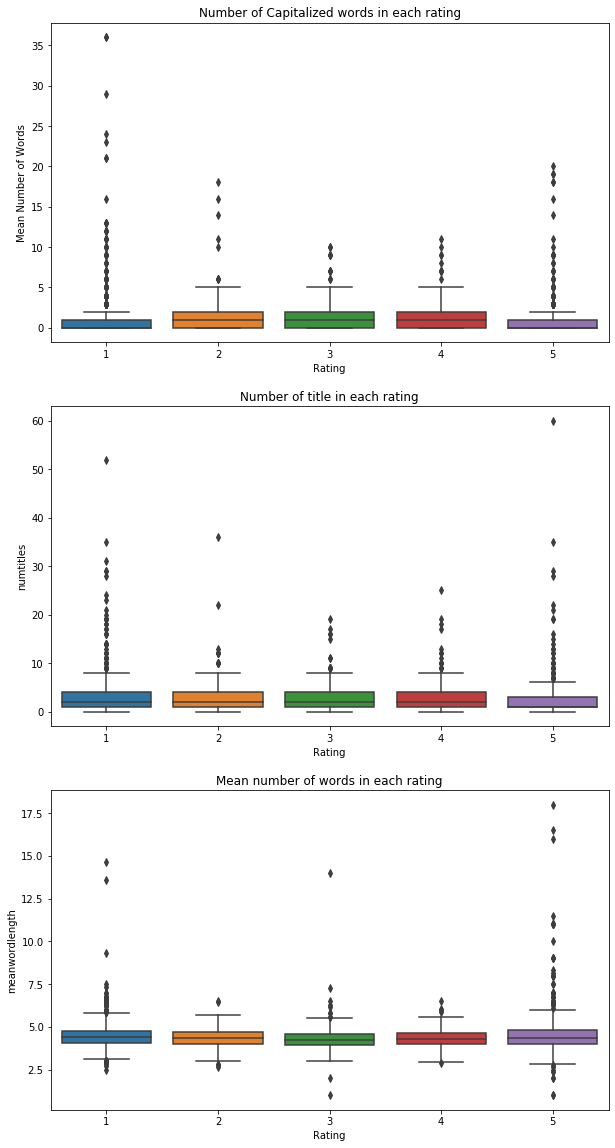

In [26]:
dfapple['numcapts'].loc[dfapple['numcapts']>36] = 36 
dfapple['numtitles'].loc[dfapple['numtitles']>60] = 60
dfapple['meanwordlength'].loc[dfapple['meanwordlength']>18] = 18

f, axes = plt.subplots(3, 1, figsize=(10,20))

sns.boxplot(x='rating', y='numcapts', data=dfapple, ax=axes[0])
axes[0].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Capitalized Words', fontsize=10)
axes[0].set_title("Number of Capitalized words in each rating", fontsize=12)

sns.boxplot(x='rating', y='numtitles', data=dfapple, ax=axes[1])
axes[1].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Number of Title Characters', fontsize=10)
axes[1].set_title("Number of title in each rating", fontsize=12)

sns.boxplot(x='rating', y='meanwordlength', data=dfapple, ax=axes[2])
axes[2].set_xlabel('Rating', fontsize=10)
axes[0].set_ylabel('Mean Number of Words', fontsize=10)
axes[2].set_title("Mean number of words in each rating", fontsize=12)
plt.show()

==================================================================================================================

# Tokenizing

In [29]:
# Remove common words
stopwords_list = stopwords.words('english') + list(string.punctuation)
# Remove more punctuation
stopwords_list += ["''", '""', '...', '``']
# Remove random numerals
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# Remove contractions
stopwords_list += ["'d", "'ve", "ca", "n't",  "'t", "'re", "'ll", "'s"]

In [30]:
def process_reviews(reviews):
    tokens = nltk.word_tokenize(reviews)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed   

In [31]:
# Separating reviews into their scores.

rating1global = dfglobal.loc[dfglobal['score'] == 1]
rating2global = dfglobal.loc[dfglobal['score'] == 2]
rating3global = dfglobal.loc[dfglobal['score'] == 3]
rating4global = dfglobal.loc[dfglobal['score'] == 4]
rating5global = dfglobal.loc[dfglobal['score'] == 5]

rating1sea = dfsea.loc[dfsea['score'] == 1]
rating2sea = dfsea.loc[dfsea['score'] == 2]
rating3sea = dfsea.loc[dfsea['score'] == 3]
rating4sea = dfsea.loc[dfsea['score'] == 4]
rating5sea = dfsea.loc[dfsea['score'] == 5]

rating1apple = dfapple.loc[dfapple['rating'] == 1]
rating2apple = dfapple.loc[dfapple['rating'] == 2]
rating3apple = dfapple.loc[dfapple['rating'] == 3]
rating4apple = dfapple.loc[dfapple['rating'] == 4]
rating5apple = dfapple.loc[dfapple['rating'] == 5]

In [32]:
starttime = datetime.now()

rating1global['wordlist'] = rating1global['content'].apply(lambda x: process_reviews(x))
rating2global['wordlist'] = rating2global['content'].apply(lambda x: process_reviews(x))
rating3global['wordlist'] = rating3global['content'].apply(lambda x: process_reviews(x))
rating4global['wordlist'] = rating4global['content'].apply(lambda x: process_reviews(x))
rating5global['wordlist'] = rating5global['content'].apply(lambda x: process_reviews(x))

rating1sea['wordlist'] = rating1sea['content'].apply(lambda x: process_reviews(x))
rating2sea['wordlist'] = rating2sea['content'].apply(lambda x: process_reviews(x))
rating3sea['wordlist'] = rating3sea['content'].apply(lambda x: process_reviews(x))
rating4sea['wordlist'] = rating4sea['content'].apply(lambda x: process_reviews(x))
rating5sea['wordlist'] = rating5sea['content'].apply(lambda x: process_reviews(x))

rating1apple['wordlist'] = rating1apple['review'].apply(lambda x: process_reviews(x))
rating2apple['wordlist'] = rating2apple['review'].apply(lambda x: process_reviews(x))
rating3apple['wordlist'] = rating3apple['review'].apply(lambda x: process_reviews(x))
rating4apple['wordlist'] = rating4apple['review'].apply(lambda x: process_reviews(x))
rating5apple['wordlist'] = rating5apple['review'].apply(lambda x: process_reviews(x))

print(datetime.now() - starttime)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

0:00:15.121141


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

In [34]:
starttime = datetime.now()

rating1global['wordlistlem'] = rating1global['wordlist'].apply(lemmatize_text)
rating2global['wordlistlem'] = rating2global['wordlist'].apply(lemmatize_text)
rating3global['wordlistlem'] = rating3global['wordlist'].apply(lemmatize_text)
rating4global['wordlistlem'] = rating4global['wordlist'].apply(lemmatize_text)
rating5global['wordlistlem'] = rating5global['wordlist'].apply(lemmatize_text)

rating1sea['wordlistlem'] = rating1sea['wordlist'].apply(lemmatize_text)
rating2sea['wordlistlem'] = rating2sea['wordlist'].apply(lemmatize_text)
rating3sea['wordlistlem'] = rating3sea['wordlist'].apply(lemmatize_text)
rating4sea['wordlistlem'] = rating4sea['wordlist'].apply(lemmatize_text)
rating5sea['wordlistlem'] = rating5sea['wordlist'].apply(lemmatize_text)

rating1apple['wordlistlem'] = rating1apple['wordlist'].apply(lemmatize_text)
rating2apple['wordlistlem'] = rating2apple['wordlist'].apply(lemmatize_text)
rating3apple['wordlistlem'] = rating3apple['wordlist'].apply(lemmatize_text)
rating4apple['wordlistlem'] = rating4apple['wordlist'].apply(lemmatize_text)
rating5apple['wordlistlem'] = rating5apple['wordlist'].apply(lemmatize_text)

print(datetime.now() - starttime)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

0:00:04.200647


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

# Saving Dataframes

In [35]:
# Saving tokens into a sub-folder in for tidiness.

from pathlib import Path

root = Path('.')

#global
my_path1 = root / "tokens" / "processedreviewrating1.pbz2"
my_path2 = root / "tokens" / "processedreviewrating2.pbz2"
my_path3 = root / "tokens" / "processedreviewrating3.pbz2"
my_path4 = root / "tokens" / "processedreviewrating4.pbz2"
my_path5 = root / "tokens" / "processedreviewrating5.pbz2"

#sea
my_path6 = root / "tokens" / "processedreviewrating6.pbz2"
my_path7 = root / "tokens" / "processedreviewrating7.pbz2"
my_path8 = root / "tokens" / "processedreviewrating8.pbz2"
my_path9 = root / "tokens" / "processedreviewrating9.pbz2"
my_path10 = root / "tokens" / "processedreviewrating10.pbz2"

#globalapple
my_path11 = root / "tokens" / "processedreviewrating11.pbz2"
my_path12 = root / "tokens" / "processedreviewrating12.pbz2"
my_path13 = root / "tokens" / "processedreviewrating13.pbz2"
my_path14 = root / "tokens" / "processedreviewrating14.pbz2"
my_path15 = root / "tokens" / "processedreviewrating15.pbz2"


import bz2

def compressed_pickle(path, data):
    with bz2.BZ2File(path, 'w') as f:
        pickle.dump(data, f)

In [36]:
compressed_pickle(my_path1, rating1global)
compressed_pickle(my_path2, rating2global)
compressed_pickle(my_path3, rating3global)
compressed_pickle(my_path4, rating4global)
compressed_pickle(my_path5, rating5global)

compressed_pickle(my_path6, rating1sea)
compressed_pickle(my_path7, rating2sea)
compressed_pickle(my_path8, rating3sea)
compressed_pickle(my_path9, rating4sea)
compressed_pickle(my_path10, rating5sea)

compressed_pickle(my_path11, rating1apple)
compressed_pickle(my_path12, rating2apple)
compressed_pickle(my_path13, rating3apple)
compressed_pickle(my_path14, rating4apple)
compressed_pickle(my_path15, rating5apple)

In [37]:
# Retrieve our pickled dataframes

rating1global = decompress_pickle(my_path1)
rating2global = decompress_pickle(my_path2)
rating3global = decompress_pickle(my_path3)
rating4global = decompress_pickle(my_path4)
rating5global = decompress_pickle(my_path5)

rating1sea = decompress_pickle(my_path6)
rating2sea = decompress_pickle(my_path7)
rating3sea = decompress_pickle(my_path8)
rating4sea = decompress_pickle(my_path9)
rating5sea = decompress_pickle(my_path10)

rating1apple = decompress_pickle(my_path11)
rating2apple = decompress_pickle(my_path12)
rating3apple = decompress_pickle(my_path13)
rating4apple = decompress_pickle(my_path14)
rating5apple = decompress_pickle(my_path15)

==================================================================================================================

# Word Frequency in all reviews

In [38]:
starttime = datetime.now()

processedreviewrating1global = [item for elem in rating1global['wordlistlem'] for item in elem]
processedreviewrating2global = [item for elem in rating2global['wordlistlem'] for item in elem]
processedreviewrating3global = [item for elem in rating3global['wordlistlem'] for item in elem]
processedreviewrating4global = [item for elem in rating4global['wordlistlem'] for item in elem]
processedreviewrating5global = [item for elem in rating5global['wordlistlem'] for item in elem]

processedreviewrating1sea = [item for elem in rating1sea['wordlistlem'] for item in elem]
processedreviewrating2sea = [item for elem in rating2sea['wordlistlem'] for item in elem]
processedreviewrating3sea = [item for elem in rating3sea['wordlistlem'] for item in elem]
processedreviewrating4sea = [item for elem in rating4sea['wordlistlem'] for item in elem]
processedreviewrating5sea = [item for elem in rating5sea['wordlistlem'] for item in elem]

processedreviewrating1apple = [item for elem in rating1apple['wordlistlem'] for item in elem]
processedreviewrating2apple = [item for elem in rating2apple['wordlistlem'] for item in elem]
processedreviewrating3apple = [item for elem in rating3apple['wordlistlem'] for item in elem]
processedreviewrating4apple = [item for elem in rating4apple['wordlistlem'] for item in elem]
processedreviewrating5apple = [item for elem in rating5apple['wordlistlem'] for item in elem]

print(datetime.now() - starttime)
print('------------')
print(len(processedreviewrating1global))
print(len(processedreviewrating2global))
print(len(processedreviewrating3global))
print(len(processedreviewrating4global))
print(len(processedreviewrating5global))
print('------------')
print(len(processedreviewrating1sea))
print(len(processedreviewrating2sea))
print(len(processedreviewrating3sea))
print(len(processedreviewrating4sea))
print(len(processedreviewrating5sea))
print('------------')
print(len(processedreviewrating1apple))
print(len(processedreviewrating2apple))
print(len(processedreviewrating3apple))
print(len(processedreviewrating4apple))
print(len(processedreviewrating5apple))

0:00:00.050909
------------
31840
8389
10838
9455
24883
------------
300098
35950
45446
41662
141578
------------
27454
5433
5650
4621
12059


In [40]:
totalprocessedreviewsglobal = processedreviewrating1global + processedreviewrating2global + processedreviewrating3global + processedreviewrating4global + processedreviewrating5global

totalprocessedreviewssea = processedreviewrating1sea + processedreviewrating2sea + processedreviewrating3sea + processedreviewrating4sea + processedreviewrating5sea

totalprocessedreviewsapple = processedreviewrating1apple + processedreviewrating2apple + processedreviewrating3apple + processedreviewrating4apple + processedreviewrating5apple

totalprocessedreviewsallglobal = totalprocessedreviewsglobal + totalprocessedreviewsapple

print(len(totalprocessedreviewsglobal))
print(len(totalprocessedreviewssea))
print(len(totalprocessedreviewsapple))
print(len(totalprocessedreviewsallglobal))

85405
564734
55217
140622


In [41]:
review_freqdistglobal = FreqDist(totalprocessedreviewsglobal)
review_freqdistsea = FreqDist(totalprocessedreviewssea)
review_freqdistapple = FreqDist(totalprocessedreviewsapple)
review_freqdistallglobal = FreqDist(totalprocessedreviewsallglobal)

print(review_freqdistglobal.most_common(20))
print('--------------------------------------------------')
print(review_freqdistsea.most_common(20))
print('--------------------------------------------------')
print(review_freqdistapple.most_common(20))
print('--------------------------------------------------')
print(review_freqdistallglobal.most_common(20))

[('game', 4844), ('play', 1156), ('time', 831), ('get', 768), ('good', 765), ('great', 699), ('love', 698), ('like', 670), ('fun', 631), ('screen', 604), ('even', 512), ('issue', 437), ('would', 423), ('fix', 421), ('day', 415), ('ragnarok', 414), ('really', 412), ('playing', 409), ('mobile', 405), ('still', 389)]
--------------------------------------------------
[('game', 33817), ('bug', 9618), ('good', 7916), ('fix', 6189), ('play', 5357), ('nice', 4872), ('player', 4591), ('please', 4426), ('love', 4263), ('time', 3887), ('great', 3557), ('cheater', 3422), ('many', 3397), ('devs', 3349), ('money', 3331), ('cant', 3248), ('like', 3240), ('still', 3160), ('server', 3047), ('update', 3039)]
--------------------------------------------------
[('game', 1728), ('’', 1427), ('jogo', 1090), ('e', 838), ('de', 720), ('que', 577), ('não', 509), ('iphone', 379), ('play', 375), ('é', 344), ('get', 323), ('time', 298), ('com', 272), ('fecha', 271), ('like', 267), ('um', 255), ('muito', 254), ('

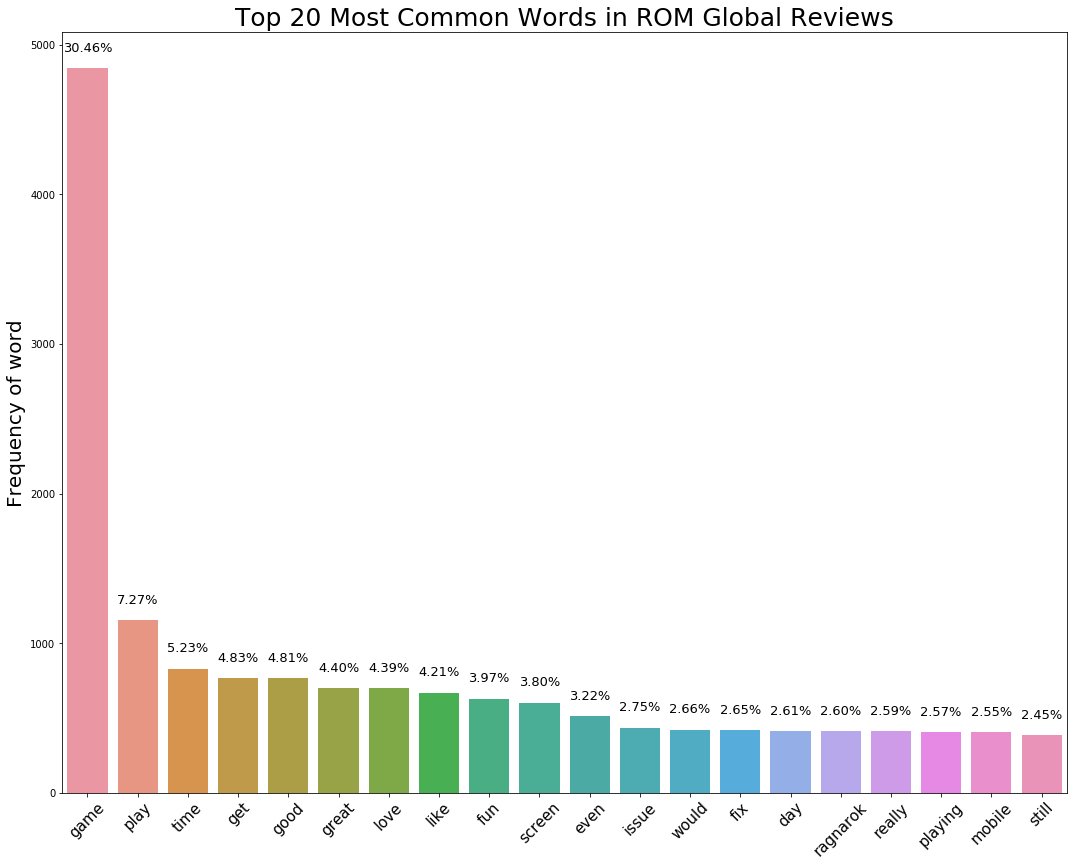

In [61]:
# Most common words in ROM Global

mostcommonwords20global = review_freqdistglobal.most_common(20)

yaxis20 = [val[1] for val in mostcommonwords20global]

xaxis20 = [val[0] for val in mostcommonwords20global]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20, yaxis20)
plt.title('Top 20 Most Common Words in ROM Global Reviews', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

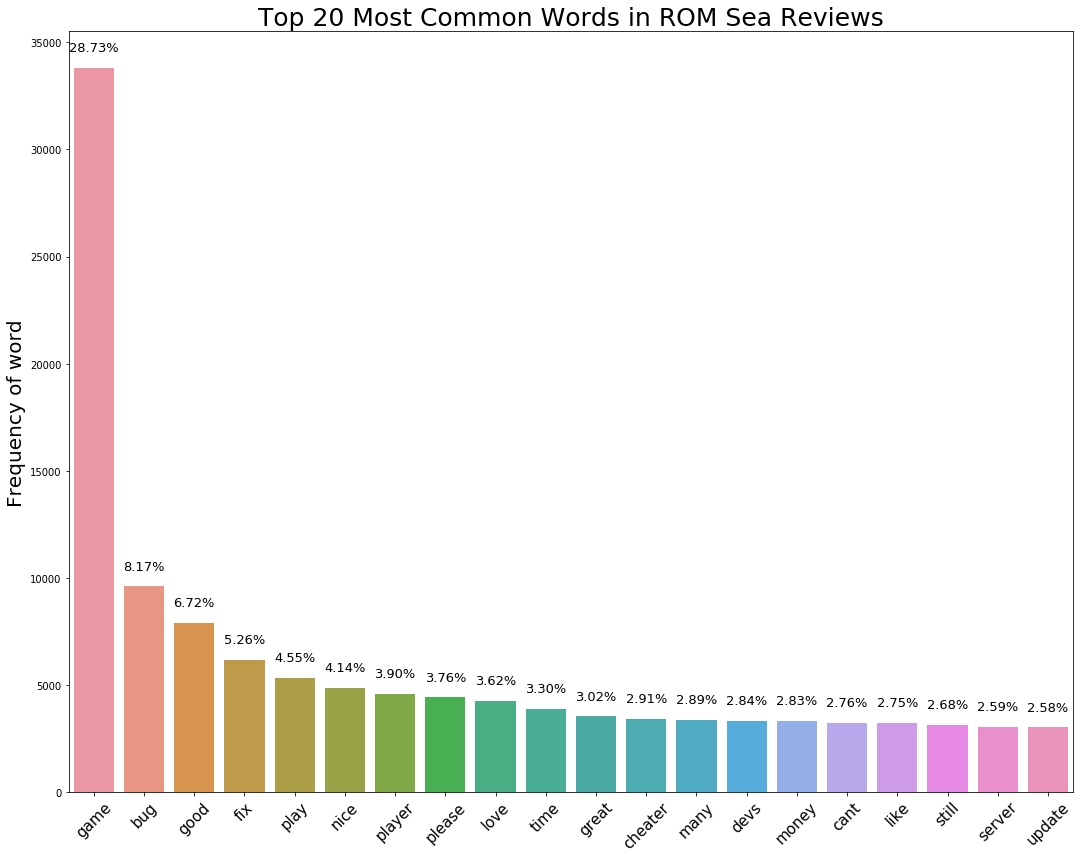

In [62]:
# Most common words in ROM Sea

mostcommonwords20sea = review_freqdistsea.most_common(20)

yaxis20 = [val[1] for val in mostcommonwords20sea]

xaxis20 = [val[0] for val in mostcommonwords20sea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20, yaxis20)
plt.title('Top 20 Most Common Words in ROM Sea Reviews', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

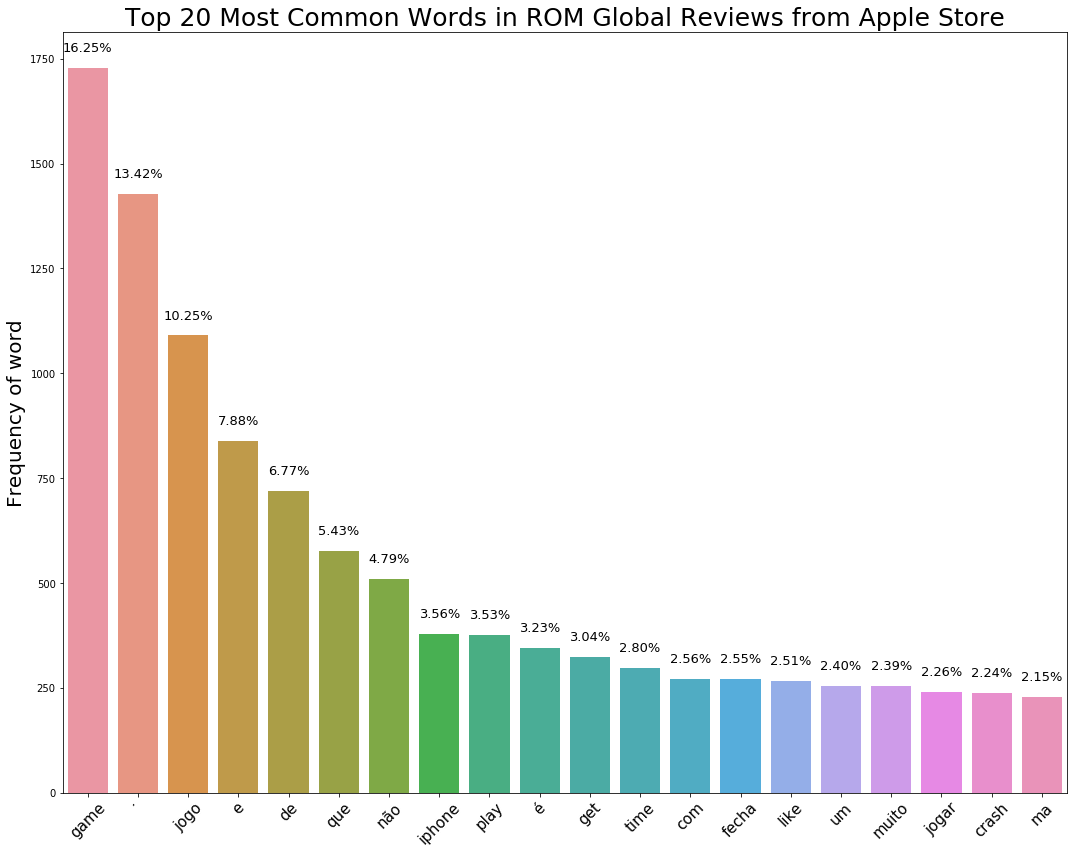

In [43]:
# Most common words in ROM Global from Apple Store

mostcommonwords20apple = review_freqdistapple.most_common(20)

yaxis20 = [val[1] for val in mostcommonwords20apple]

xaxis20 = [val[0] for val in mostcommonwords20apple]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20, yaxis20)
plt.title('Top 20 Most Common Words in ROM Global Reviews from Apple Store', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [ ]:
# Most common words in ROM all Global

mostcommonwords20allglobal = review_freqdistallglobal.most_common(20)

yaxis20 = [val[1] for val in mostcommonwords20allglobal]

xaxis20 = [val[0] for val in mostcommonwords20allglobal]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20, yaxis20)
plt.title('Top 20 Most Common Words in ROM Global Reviews f', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

# Top 20 words per Rating [Lemmatized] for Global

In [63]:
uselesswords = ['game', 'play', 'get', 'still', 'would']

In [65]:
processedreviewrating1global[:] = [x for x in processedreviewrating1global if x not in uselesswords]

review1_freqdistglobal = FreqDist(processedreviewrating1global)
review1_freqdistglobal.most_common(20)

[('even', 340),
 ('time', 332),
 ('screen', 270),
 ('fix', 196),
 ('money', 185),
 ('player', 177),
 ('start', 174),
 ('app', 168),
 ('issue', 165),
 ('day', 163),
 ('download', 159),
 ('phone', 154),
 ('account', 152),
 ('cant', 149),
 ('update', 148),
 ('like', 144),
 ('keep', 137),
 ('open', 137),
 ('log', 131),
 ('every', 124)]

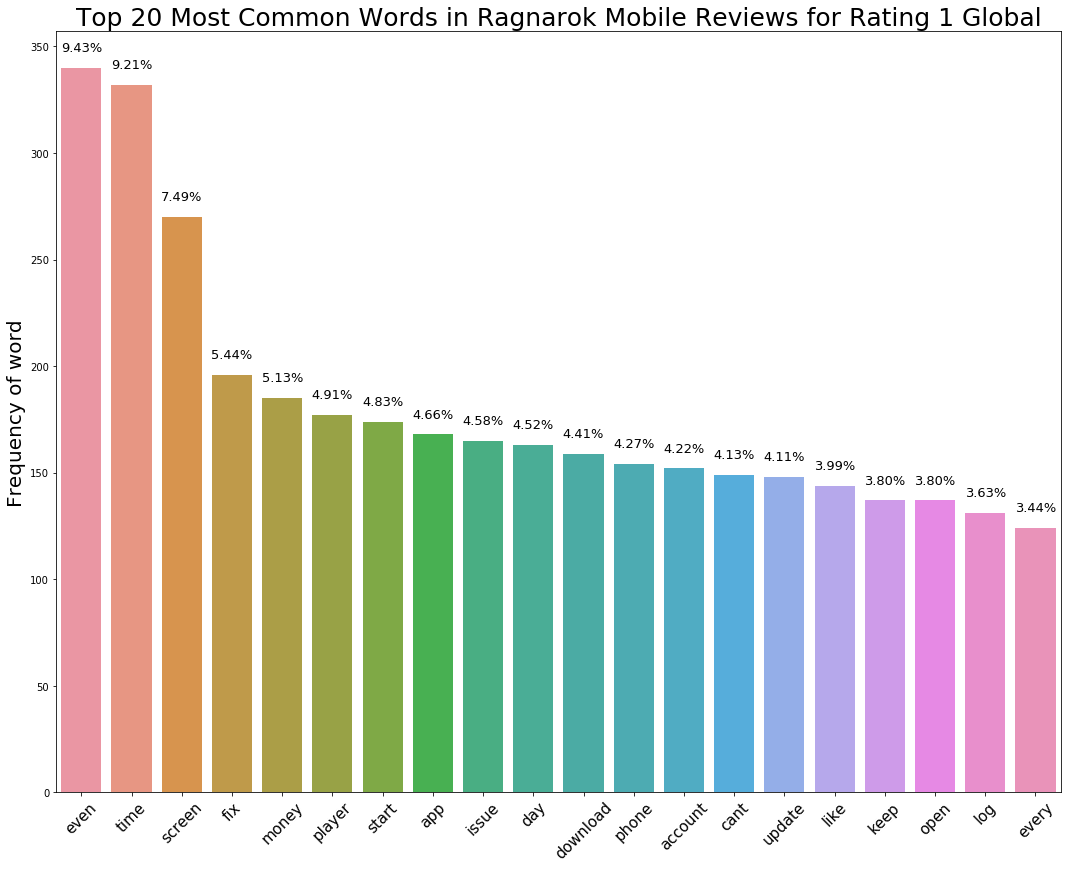

In [66]:
mostcommonwords201global = review1_freqdistglobal.most_common(20)

yaxis201global = [val[1] for val in mostcommonwords201global]

xaxis201global = [val[0] for val in mostcommonwords201global]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis201global, yaxis201global)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 1 Global', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis201global))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [67]:
processedreviewrating2global[:] = [x for x in processedreviewrating2global if x not in uselesswords]

review2_freqdistglobal = FreqDist(processedreviewrating2global)
review2_freqdistglobal.most_common(20)

[('screen', 95),
 ('time', 90),
 ('issue', 64),
 ('fix', 58),
 ('start', 53),
 ('reinstall', 52),
 ('like', 51),
 ('log', 50),
 ('day', 50),
 ('even', 48),
 ('phone', 45),
 ('really', 45),
 ('every', 45),
 ('good', 44),
 ('playing', 43),
 ('work', 43),
 ('update', 42),
 ('login', 42),
 ('star', 42),
 ('make', 39)]

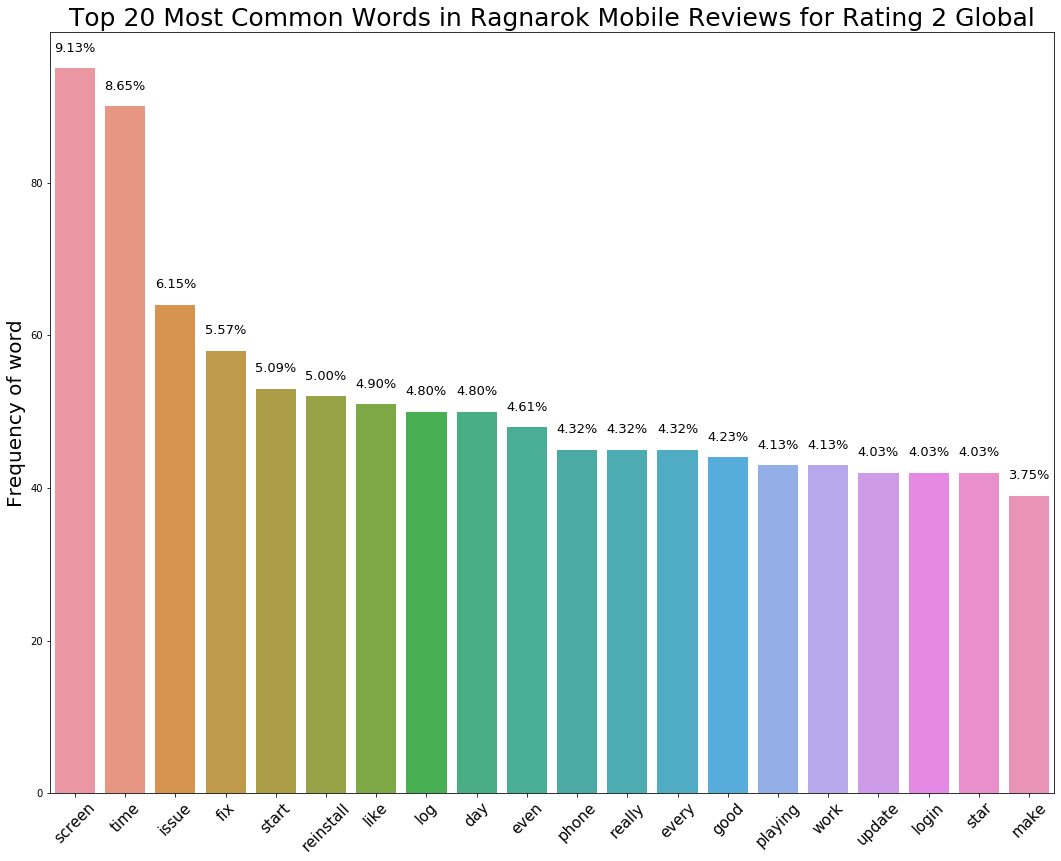

In [68]:
mostcommonwords202global = review2_freqdistglobal.most_common(20)

yaxis202global = [val[1] for val in mostcommonwords202global]

xaxis202global = [val[0] for val in mostcommonwords202global]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis202global, yaxis202global)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 2 Global', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis202global))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [69]:
processedreviewrating3global[:] = [x for x in processedreviewrating3global if x not in uselesswords]

review3_freqdistglobal = FreqDist(processedreviewrating3global)
review3_freqdistglobal.most_common(20)

[('time', 124),
 ('screen', 112),
 ('like', 98),
 ('good', 87),
 ('star', 82),
 ('fix', 81),
 ('issue', 74),
 ('start', 73),
 ('every', 70),
 ('great', 65),
 ('reinstall', 64),
 ('playing', 63),
 ('fun', 63),
 ('day', 62),
 ("'m", 60),
 ('really', 59),
 ('need', 58),
 ('login', 56),
 ('log', 56),
 ('update', 52)]

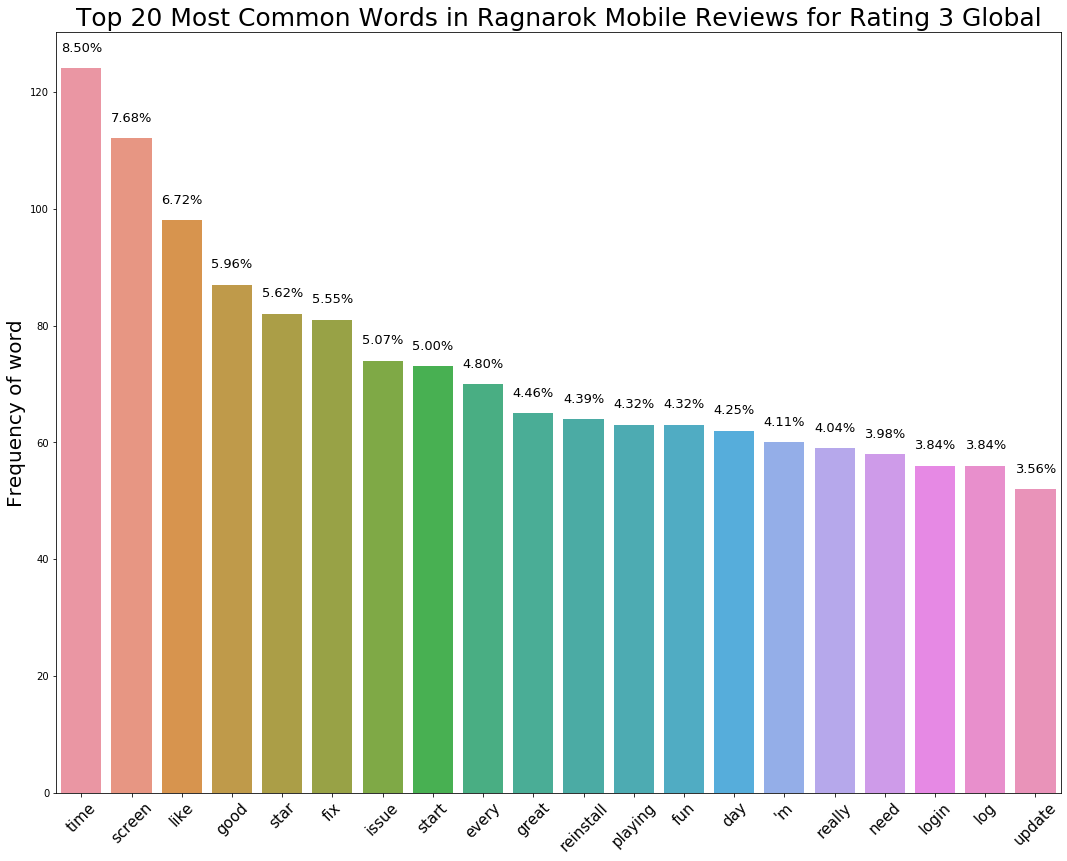

In [70]:
mostcommonwords203global = review3_freqdistglobal.most_common(20)

yaxis203global = [val[1] for val in mostcommonwords203global]

xaxis203global = [val[0] for val in mostcommonwords203global]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis203global, yaxis203global)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 3 Global', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis203global))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [71]:
processedreviewrating4global[:] = [x for x in processedreviewrating4global if x not in uselesswords]

review4_freqdistglobal = FreqDist(processedreviewrating4global)
review4_freqdistglobal.most_common(20)

[('good', 134),
 ('great', 114),
 ('fun', 100),
 ('like', 87),
 ('time', 85),
 ('love', 78),
 ('screen', 68),
 ('issue', 67),
 ('really', 56),
 ('ragnarok', 55),
 ('star', 55),
 ('mobile', 54),
 ('ro', 54),
 ('far', 52),
 ('playing', 50),
 ('lot', 49),
 ('pretty', 49),
 ('original', 46),
 ('fix', 45),
 ('one', 43)]

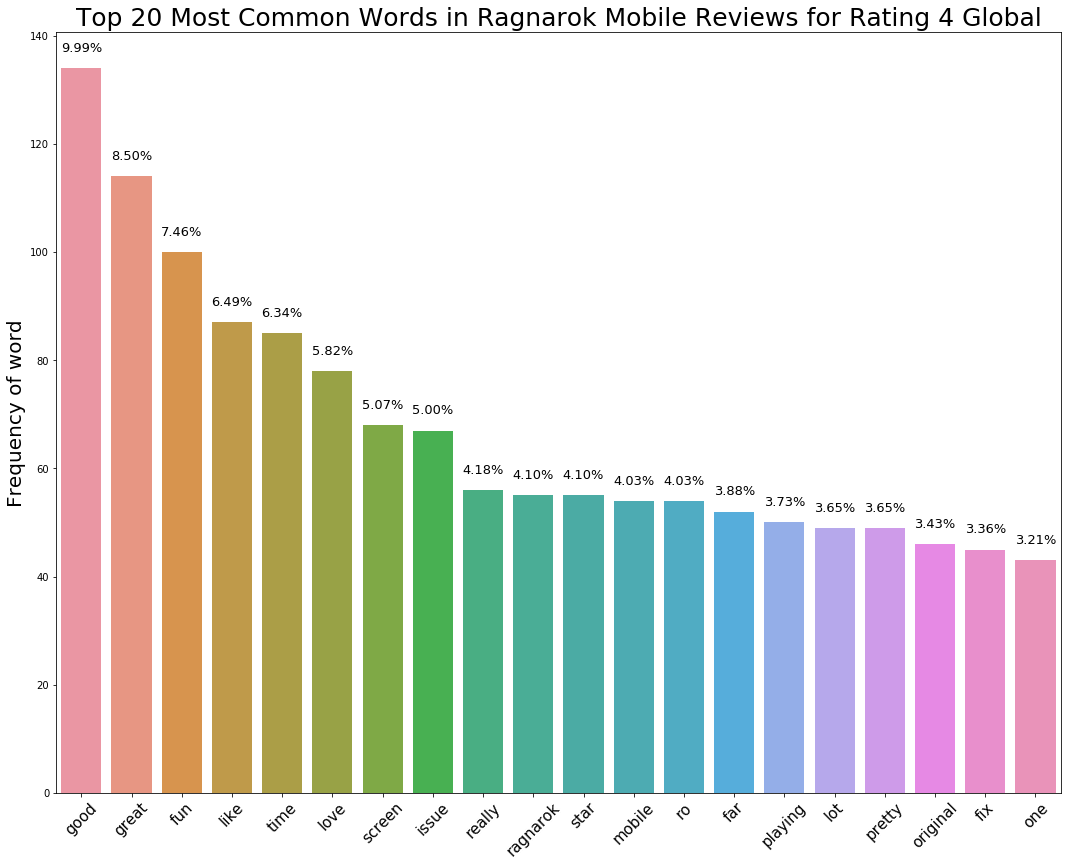

In [72]:
mostcommonwords204global = review4_freqdistglobal.most_common(20)

yaxis204global = [val[1] for val in mostcommonwords204global]

xaxis204global = [val[0] for val in mostcommonwords204global]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis204global, yaxis204global)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 4 Global', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis204global))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [73]:
processedreviewrating5global[:] = [x for x in processedreviewrating5global if x not in uselesswords]

review5_freqdistglobal = FreqDist(processedreviewrating5global)
review5_freqdistglobal.most_common(20)

[('love', 471),
 ('great', 420),
 ('good', 413),
 ('fun', 371),
 ('like', 290),
 ('mobile', 256),
 ('ragnarok', 240),
 ('ro', 236),
 ('back', 215),
 ('best', 207),
 ('time', 200),
 ('original', 186),
 ('old', 170),
 ('really', 166),
 ('amazing', 164),
 ('far', 161),
 ('awesome', 160),
 ('played', 152),
 ('nice', 144),
 ('pc', 142)]

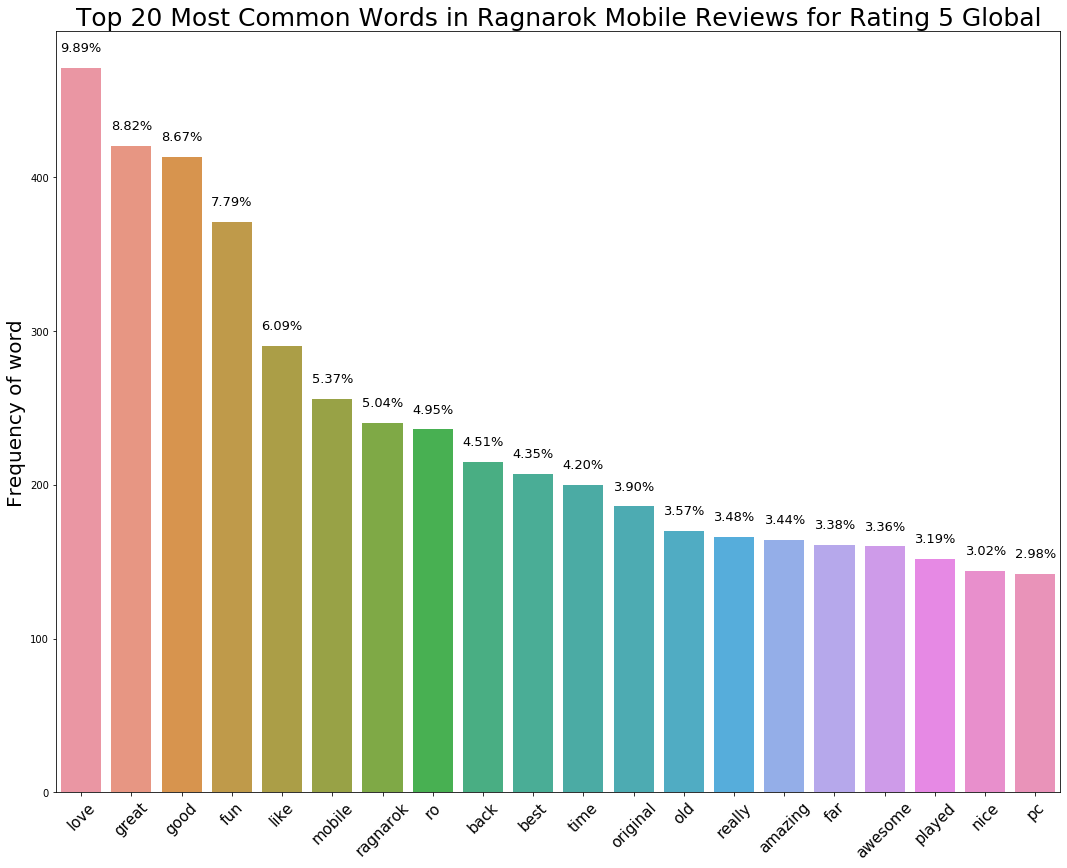

In [74]:
mostcommonwords205global = review5_freqdistglobal.most_common(20)

yaxis205global = [val[1] for val in mostcommonwords205global]

xaxis205global = [val[0] for val in mostcommonwords205global]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis205global, yaxis205global)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 5 Global', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis205global))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

# Top 20 words per Rating [Lemmatized] for SEA

In [75]:
processedreviewrating1sea[:] = [x for x in processedreviewrating1sea if x not in uselesswords]

review1_freqdistsea = FreqDist(processedreviewrating1sea)
review1_freqdistsea.most_common(20)

[('bug', 7393),
 ('fix', 3655),
 ('cheater', 3231),
 ('player', 3153),
 ('money', 2945),
 ('devs', 2817),
 ('many', 2614),
 ('ban', 2324),
 ('lag', 2246),
 ('time', 2155),
 ('server', 2146),
 ('please', 1878),
 ('even', 1878),
 ('developer', 1860),
 ('update', 1791),
 ('cant', 1763),
 ('issue', 1578),
 ('day', 1452),
 ('lot', 1401),
 ('star', 1364)]

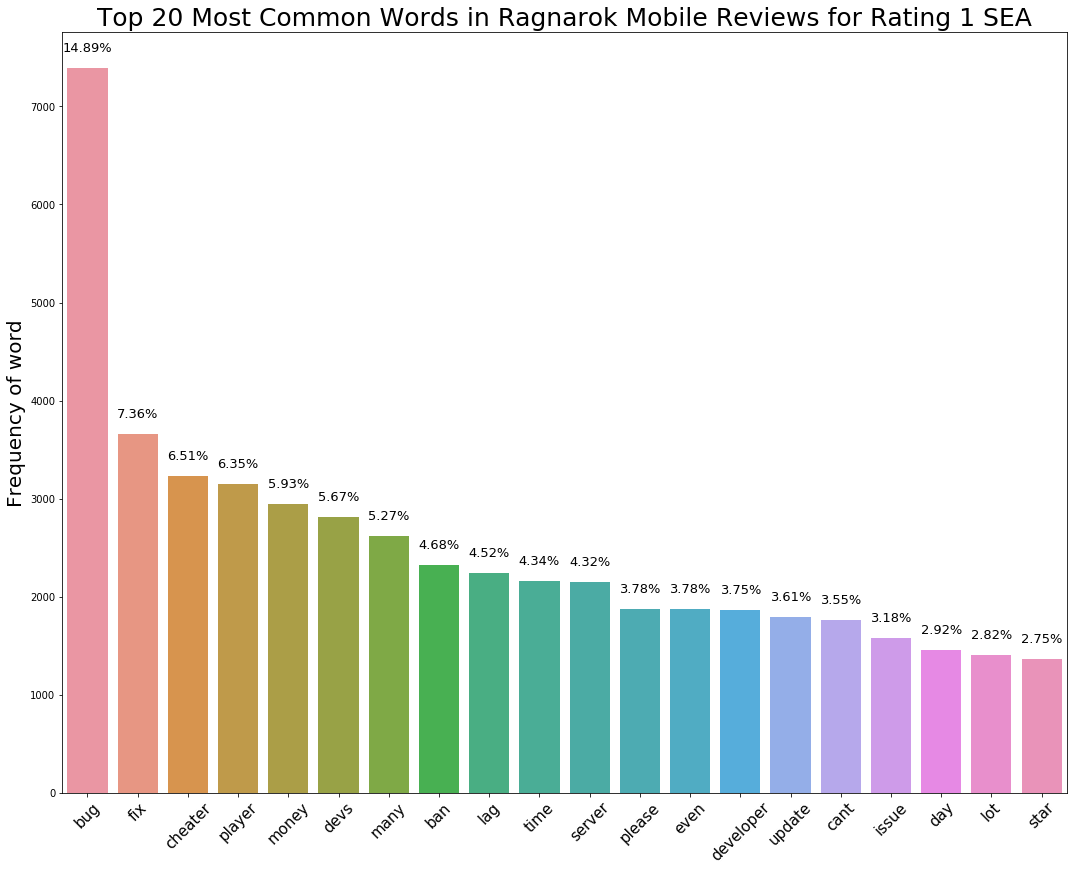

In [76]:
mostcommonwords201sea = review1_freqdistsea.most_common(20)

yaxis201sea = [val[1] for val in mostcommonwords201sea]

xaxis201sea = [val[0] for val in mostcommonwords201sea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis201sea, yaxis201sea)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 1 SEA', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis201sea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [77]:
processedreviewrating2sea[:] = [x for x in processedreviewrating2sea if x not in uselesswords]

review2_freqdistsea = FreqDist(processedreviewrating2sea)
review2_freqdistsea.most_common(20)

[('fix', 507),
 ('please', 417),
 ('bug', 391),
 ('cant', 336),
 ('update', 327),
 ('time', 316),
 ('screen', 308),
 ('login', 288),
 ('player', 266),
 ('stuck', 258),
 ('even', 226),
 ('problem', 219),
 ('like', 216),
 ('good', 211),
 ('always', 204),
 ('log', 187),
 ('character', 187),
 ('phone', 176),
 ('server', 169),
 ('loading', 168)]

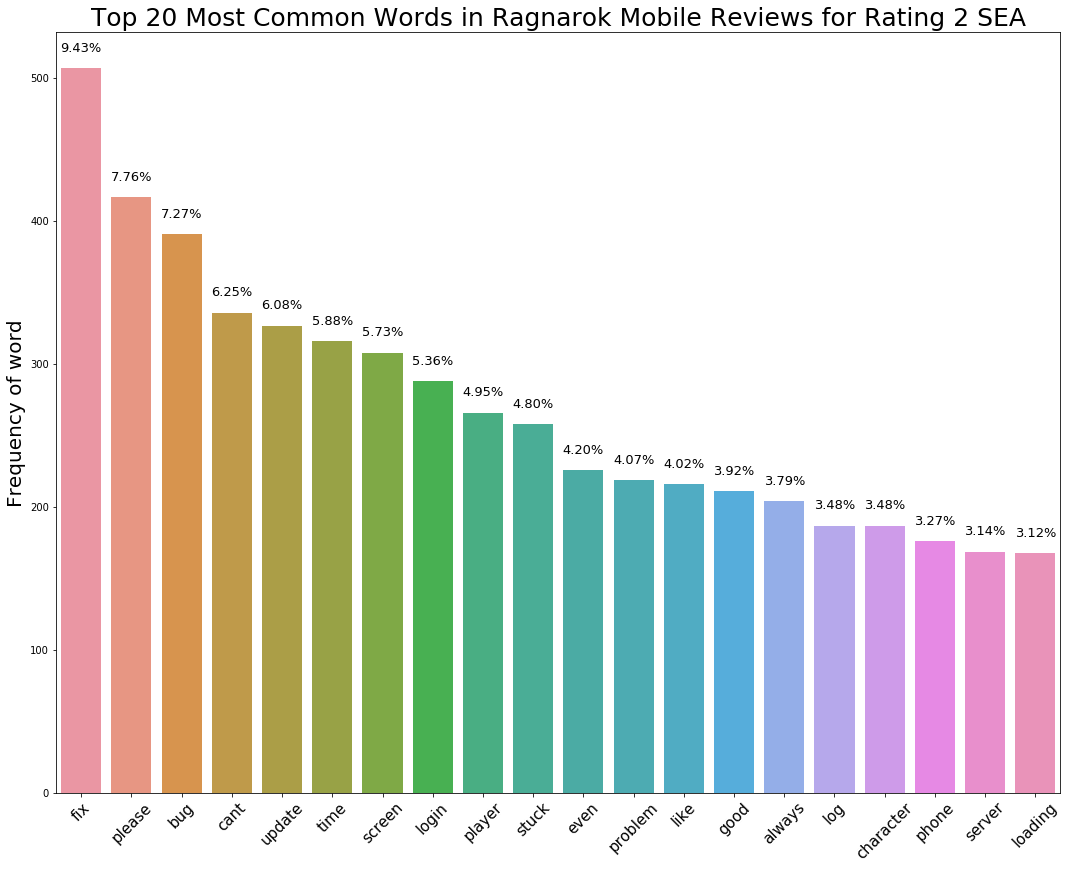

In [78]:
mostcommonwords202sea = review2_freqdistsea.most_common(20)

yaxis202sea = [val[1] for val in mostcommonwords202sea]

xaxis202sea = [val[0] for val in mostcommonwords202sea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis202sea, yaxis202sea)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 2 SEA', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis202sea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [79]:
processedreviewrating3sea[:] = [x for x in processedreviewrating3sea if x not in uselesswords]

review3_freqdistsea = FreqDist(processedreviewrating3sea)
review3_freqdistsea.most_common(20)

[('fix', 672),
 ('please', 617),
 ('bug', 536),
 ('good', 455),
 ('cant', 436),
 ('screen', 377),
 ('time', 329),
 ('stuck', 325),
 ('update', 308),
 ('character', 301),
 ('player', 298),
 ('login', 298),
 ('log', 297),
 ('like', 289),
 ('loading', 270),
 ('problem', 253),
 ('help', 239),
 ('need', 229),
 ('many', 225),
 ('phone', 214)]

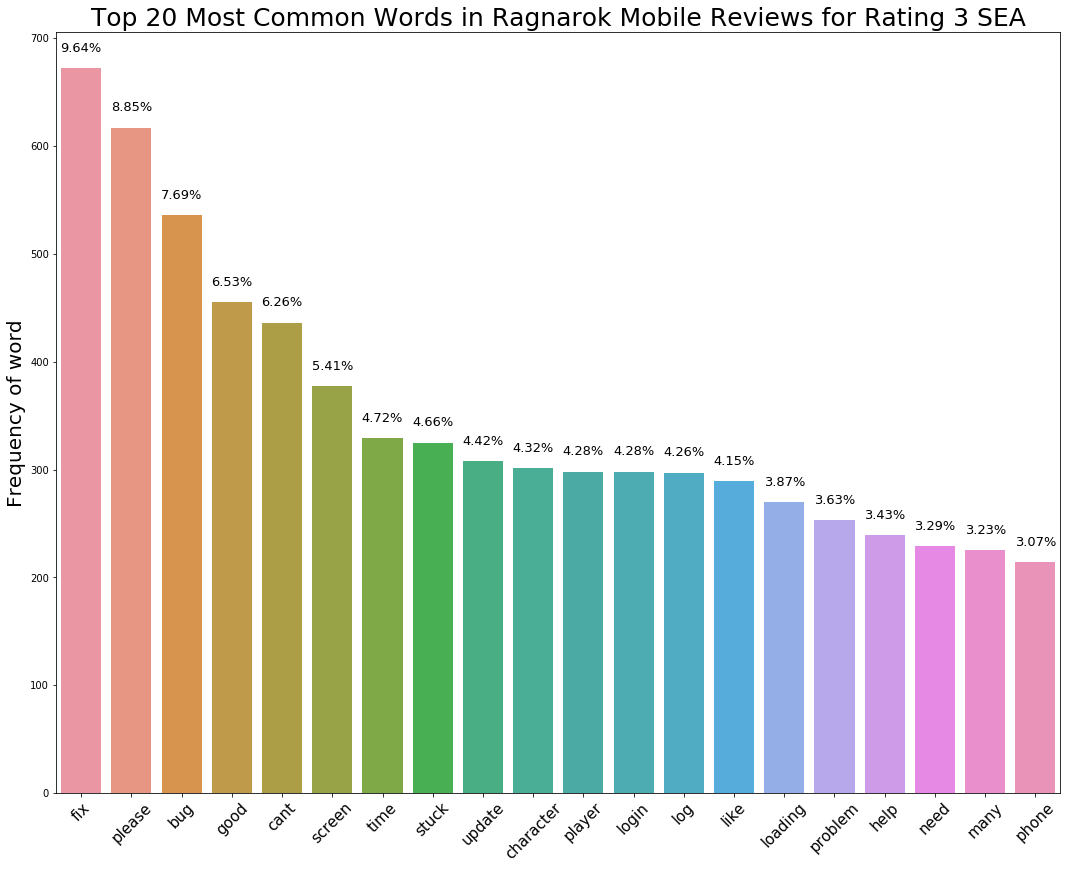

In [80]:
mostcommonwords203sea = review3_freqdistsea.most_common(20)

yaxis203sea = [val[1] for val in mostcommonwords203sea]

xaxis203sea = [val[0] for val in mostcommonwords203sea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis203sea, yaxis203sea)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 3 SEA', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis203sea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [81]:
processedreviewrating4sea[:] = [x for x in processedreviewrating4sea if x not in uselesswords]

review4_freqdistsea = FreqDist(processedreviewrating4sea)
review4_freqdistsea.most_common(20)

[('good', 888),
 ('please', 519),
 ('fix', 503),
 ('bug', 501),
 ('nice', 449),
 ('great', 354),
 ('like', 327),
 ('player', 281),
 ('time', 270),
 ('cant', 263),
 ('love', 243),
 ('need', 234),
 ('star', 228),
 ('update', 223),
 ('screen', 213),
 ('hope', 205),
 ('make', 197),
 ('login', 194),
 ('back', 183),
 ('stuck', 181)]

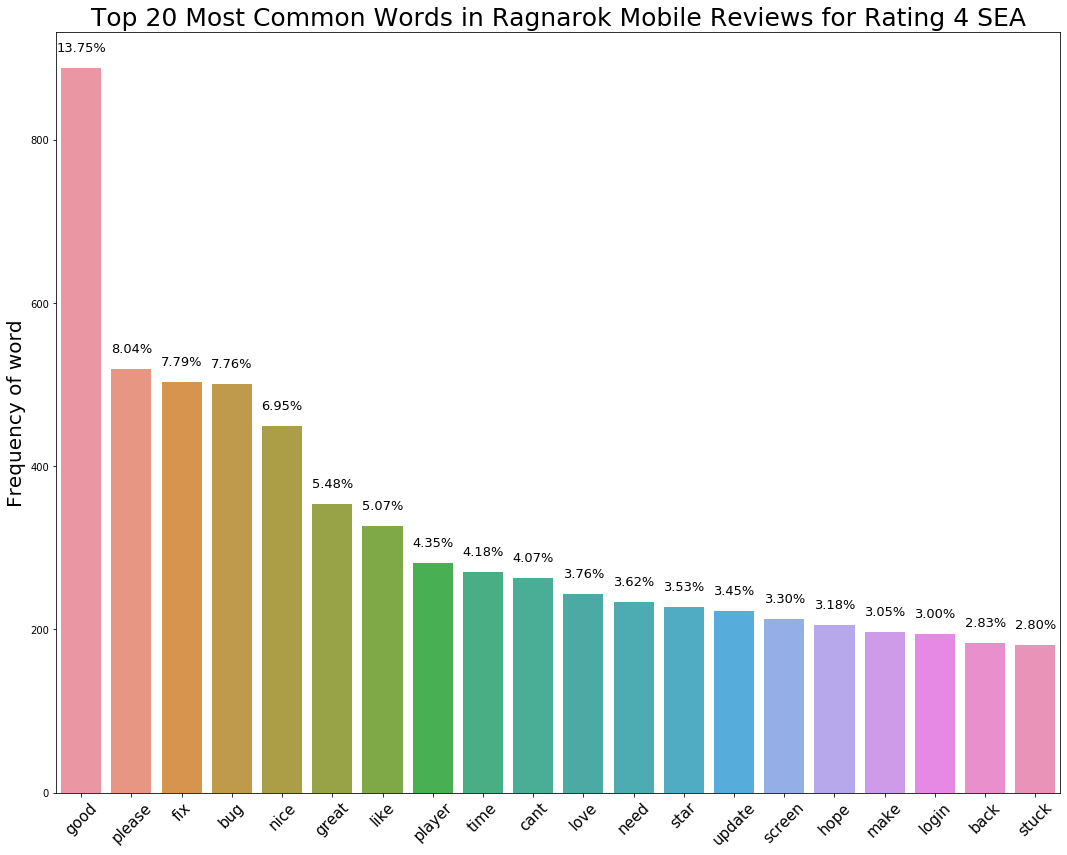

In [82]:
mostcommonwords204sea = review4_freqdistsea.most_common(20)

yaxis204sea = [val[1] for val in mostcommonwords204sea]

xaxis204sea = [val[0] for val in mostcommonwords204sea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis204sea, yaxis204sea)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 4 SEA', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis204sea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [83]:
processedreviewrating5sea[:] = [x for x in processedreviewrating5sea if x not in uselesswords]

review5_freqdistsea = FreqDist(processedreviewrating5sea)
review5_freqdistsea.most_common(20)

[('good', 5042),
 ('nice', 4070),
 ('love', 2993),
 ('great', 2533),
 ('best', 2183),
 ('back', 1411),
 ('awesome', 1356),
 ('like', 1228),
 ('ragnarok', 1102),
 ('please', 995),
 ('nostalgic', 939),
 ('ever', 867),
 ('old', 863),
 ('fix', 852),
 ('time', 817),
 ('memory', 810),
 ('bug', 797),
 ('mobile', 711),
 ('fun', 677),
 ('really', 662)]

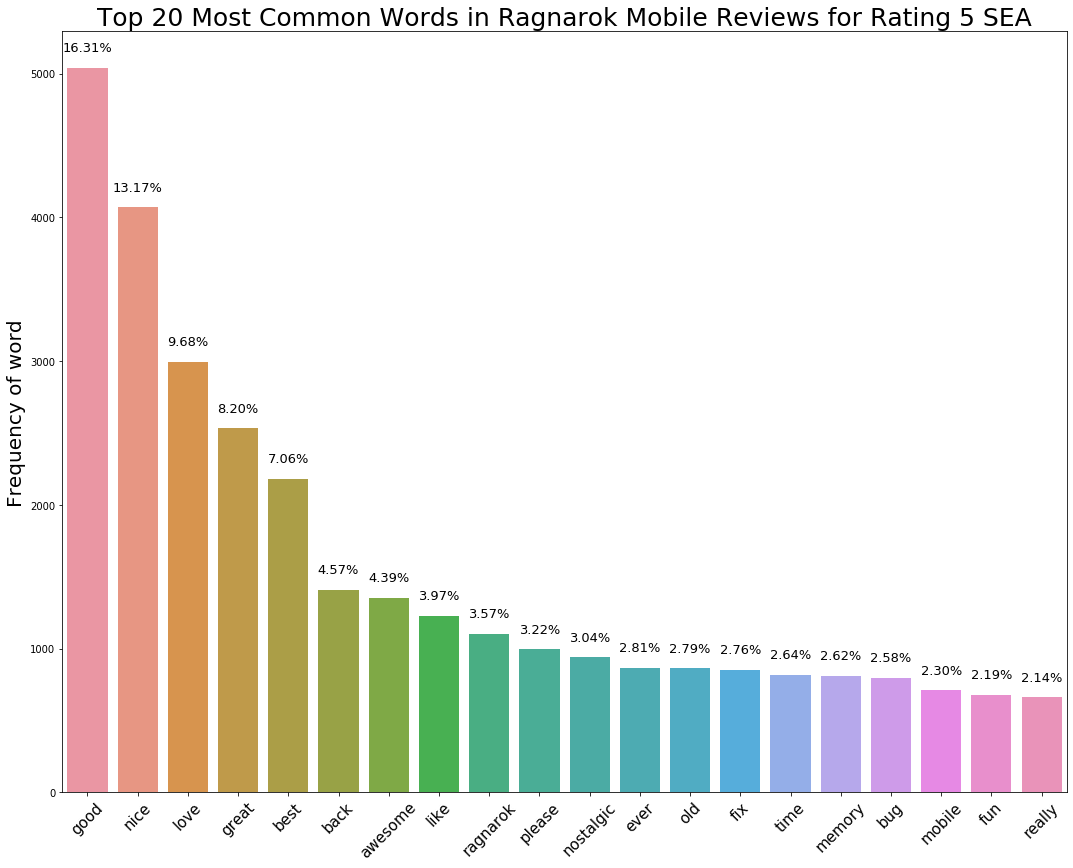

In [84]:
mostcommonwords205sea = review5_freqdistsea.most_common(20)

yaxis205sea = [val[1] for val in mostcommonwords205sea]

xaxis205sea = [val[0] for val in mostcommonwords205sea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis205sea, yaxis205sea)
plt.title('Top 20 Most Common Words in Ragnarok Mobile Reviews for Rating 5 SEA', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15)

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis205sea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

# Bigrams/Trigrams overall for Global

In [85]:
def n_gramall(df_col, n=None):
    # Build the vectorizer, specify inputted n-gram, remove stop words
    vect = CountVectorizer(ngram_range = (n,n), stop_words = gramstopwords_list, min_df = 10)
    # fit/transform vectorizer on specified column
    vect_fit = vect.fit_transform(df_col.values.astype('U'))
    # get all words and store in a list
    word_list = vect.get_feature_names()
    # get a count of all the words
    count_list = vect_fit.toarray().sum(axis=0)
    #create a dictionary of word to count pairings
    count_dict = dict(zip(word_list, count_list))
    # sort the dictionary to show highest counted words on top
    sort_vocab = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)
    return sort_vocab

In [86]:
gramstopwords_list = stopwords.words('english') + list(string.punctuation)
gramstopwords_list += ["''", '""', '...', '``']

In [88]:
bigramallglobal = n_gramall(dfglobal['content'], n=2)
bigramallglobal[:20]

[('great game', 287),
 ('love game', 211),
 ('play game', 183),
 ('good game', 179),
 ('please fix', 128),
 ('fun game', 115),
 ('pay win', 112),
 ('brings back', 109),
 ('ragnarok online', 97),
 ('uninstall reinstall', 85),
 ('reinstall game', 84),
 ('game play', 76),
 ('start game', 75),
 ('playing game', 74),
 ('touch start', 74),
 ('start screen', 72),
 ('every time', 70),
 ('game great', 70),
 ('mobile game', 70),
 ('login screen', 66)]

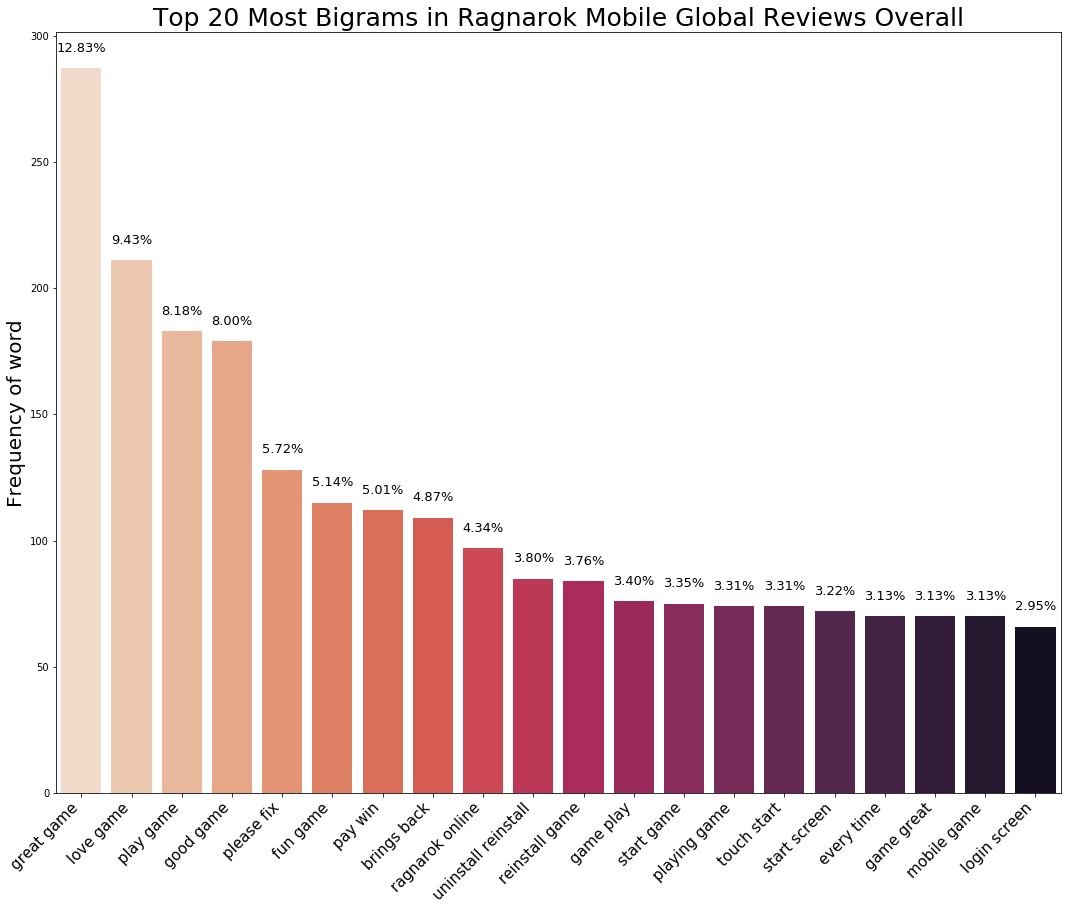

In [89]:
mostcommonwords20bigramglobal = bigramallglobal[:20]

yaxis20bigramglobal = [val[1] for val in mostcommonwords20bigramglobal]

xaxis20biramglobal = [val[0] for val in mostcommonwords20bigramglobal]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20biramglobal, yaxis20bigramglobal, palette ="rocket_r")
plt.title('Top 20 Most Bigrams in Ragnarok Mobile Global Reviews Overall', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20bigramglobal))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [90]:
trigramallglobal = n_gramall(dfglobal['content'], n=3)
trigramallglobal[:20]

[('best game ever', 36),
 ('brings back memories', 32),
 ('uninstall reinstall game', 29),
 ('touch start game', 27),
 ('game brings back', 25),
 ('stuck loading screen', 23),
 ('using google account', 23),
 ('stuck login screen', 21),
 ('original ragnarok online', 20),
 ('touch start screen', 20),
 ('cant even play', 16),
 ('cant get past', 16),
 ('brings back many', 15),
 ('past touch start', 15),
 ('screen please fix', 14),
 ('brings back old', 13),
 ('stuck title screen', 13),
 ('tried clearing cache', 13),
 ('able play game', 12),
 ('even play game', 12)]

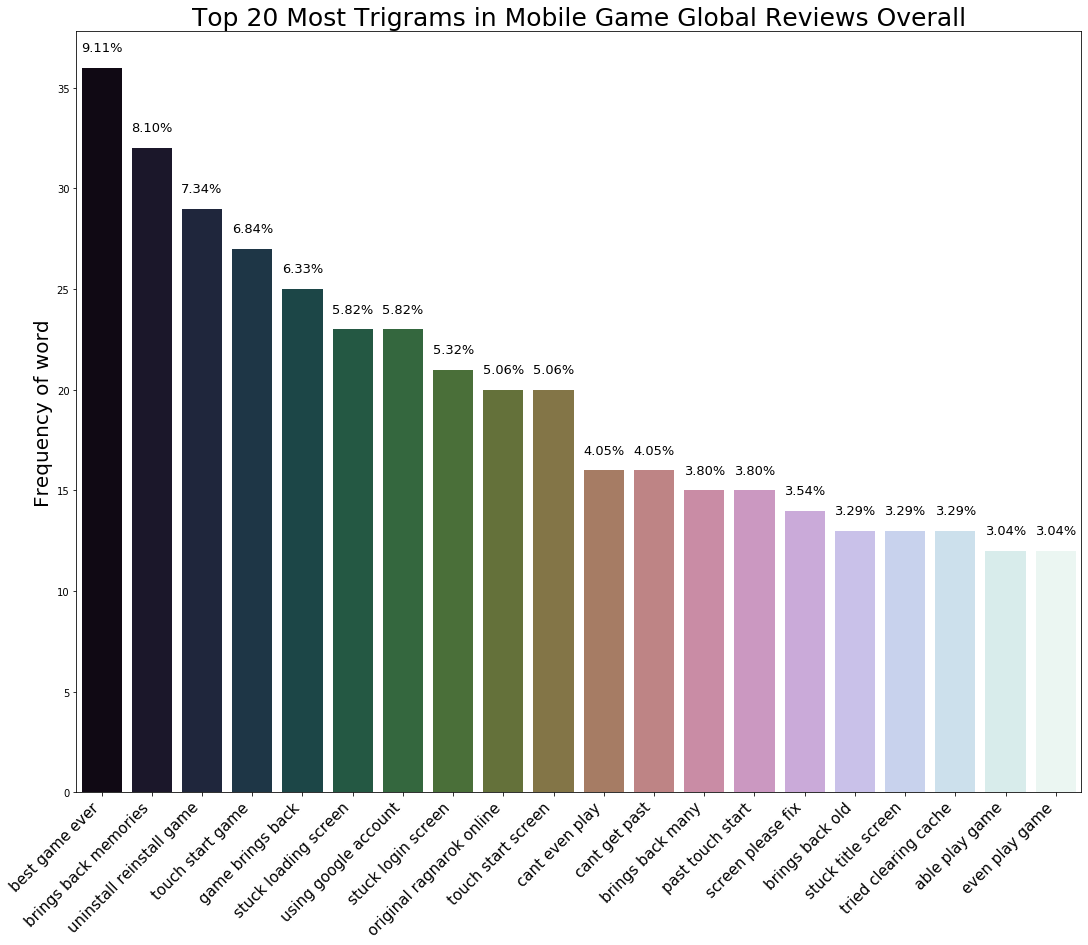

In [91]:
mostcommonwords20trigramglobal = trigramallglobal[:20]

yaxis20trigramglobal = [val[1] for val in mostcommonwords20trigramglobal]

xaxis20triramglobal = [val[0] for val in mostcommonwords20trigramglobal]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20triramglobal, yaxis20trigramglobal, palette ="cubehelix")
plt.title('Top 20 Most Trigrams in Mobile Game Global Reviews Overall', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')

for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20trigramglobal))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

# Bigrams/Trigrams overall for SEA

In [92]:
bigramallsea = n_gramall(dfsea['content'], n=2)
bigramallsea[:20]

[('good game', 2397),
 ('nice game', 2152),
 ('please fix', 1795),
 ('great game', 1689),
 ('love game', 1667),
 ('play game', 1312),
 ('pay win', 1115),
 ('many bugs', 961),
 ('3rd party', 907),
 ('best game', 883),
 ('game ever', 836),
 ('black screen', 766),
 ('add ons', 728),
 ('loading screen', 668),
 ('woe woc', 619),
 ('stuck loading', 605),
 ('game good', 582),
 ('playing game', 566),
 ('fix bugs', 531),
 ('15 days', 489)]

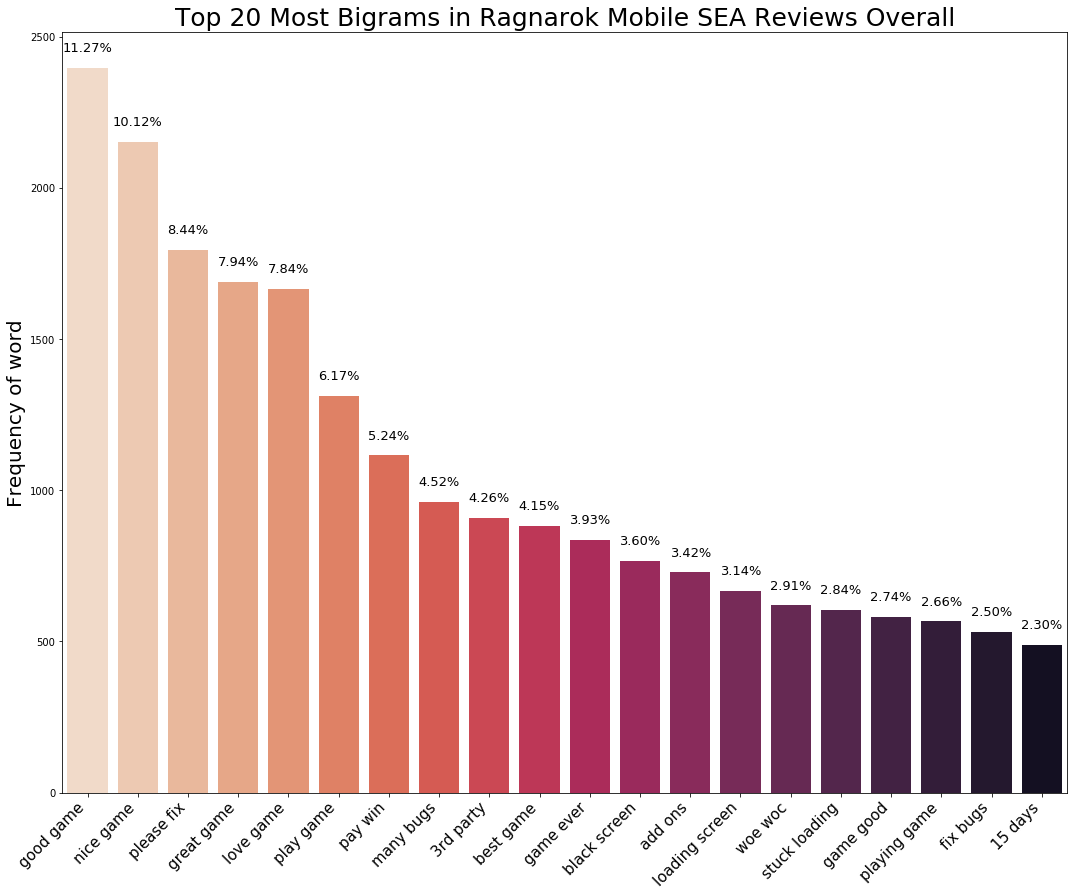

In [93]:
mostcommonwords20bigramsea = bigramallsea[:20]

yaxis20bigramsea = [val[1] for val in mostcommonwords20bigramsea]

xaxis20biramsea = [val[0] for val in mostcommonwords20bigramsea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis20biramsea, yaxis20bigramsea, palette ="rocket_r")
plt.title('Top 20 Most Bigrams in Ragnarok Mobile SEA Reviews Overall', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis20bigramsea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

# Bigrams/Trigrams for specific ratings for ROM Global

In [94]:
# Rating 1

bigram1global = n_gramall(rating1global['content'], n=2)
bigram1global[:20]

[('play game', 104),
 ('pay win', 64),
 ('please fix', 59),
 ('cant even', 42),
 ('black screen', 39),
 ('start game', 38),
 ('even play', 36),
 ('loading screen', 34),
 ('reinstall game', 33),
 ('uninstall reinstall', 33),
 ('download game', 32),
 ('google account', 32),
 ('every time', 30),
 ('great game', 29),
 ('start screen', 29),
 ('playing game', 28),
 ('get past', 27),
 ('get game', 26),
 ('open game', 26),
 ('waste time', 26)]

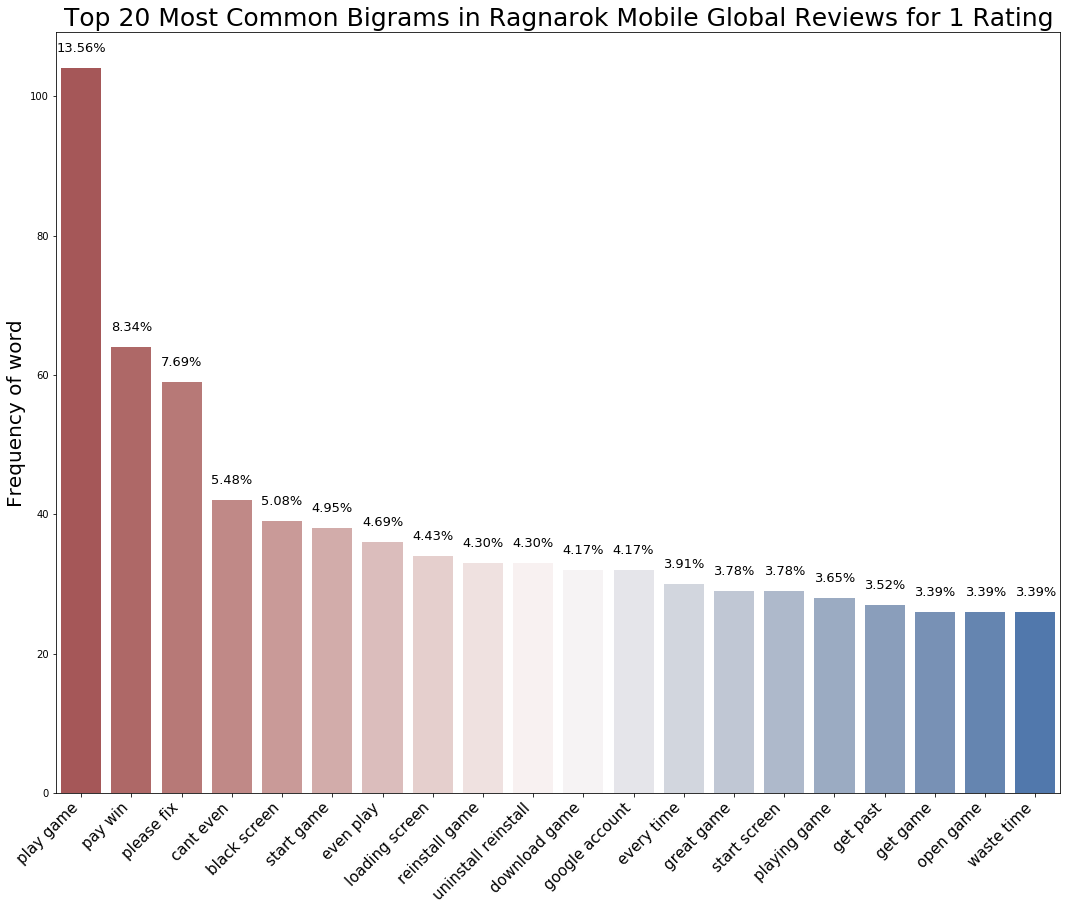

In [95]:
mostcommonwords201biglobal = bigram1global[:20]

yaxis201biglobal = [val[1] for val in mostcommonwords201biglobal]

xaxis201biglobal = [val[0] for val in mostcommonwords201biglobal]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis201biglobal, yaxis201biglobal, palette ="vlag_r")
plt.title('Top 20 Most Common Bigrams in Ragnarok Mobile Global Reviews for 1 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis201biglobal))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [97]:
trigram1global = n_gramall(rating1global['content'], n=3)
trigram1global[:20]

[('using google account', 14),
 ('cant even play', 13),
 ('stuck loading screen', 12),
 ('uninstall reinstall game', 11),
 ('touch start game', 10)]

-------

In [99]:
# Rating 2

bigram2global = n_gramall(rating2global['content'], n=2)
bigram2global[:20]

[('play game', 23),
 ('please fix', 19),
 ('reinstall game', 19),
 ('every time', 16),
 ('good game', 15),
 ('love game', 15),
 ('uninstall reinstall', 15),
 ('login screen', 13),
 ('great game', 12),
 ('fun game', 11),
 ('like game', 11),
 ('able play', 10),
 ('start game', 10),
 ('touch start', 10)]

In [ ]:
# Returns nothing.

#trigram2 = n_gramall(rating2['content'], n=3)
#trigram2[:20]

--------

In [100]:
# Rating 3

bigram3global = n_gramall(rating3global['content'], n=2)
bigram3global[:20]

[('love game', 30),
 ('good game', 28),
 ('great game', 25),
 ('please fix', 23),
 ('uninstall reinstall', 21),
 ('touch start', 20),
 ('reinstall game', 19),
 ('start game', 18),
 ('every days', 16),
 ('fun game', 16),
 ('like game', 16),
 ('login screen', 16),
 ('play game', 15),
 ('every time', 14),
 ('start screen', 14),
 ('game great', 13),
 ('give stars', 13),
 ('game good', 12),
 ('game would', 12),
 ('gets stuck', 12)]

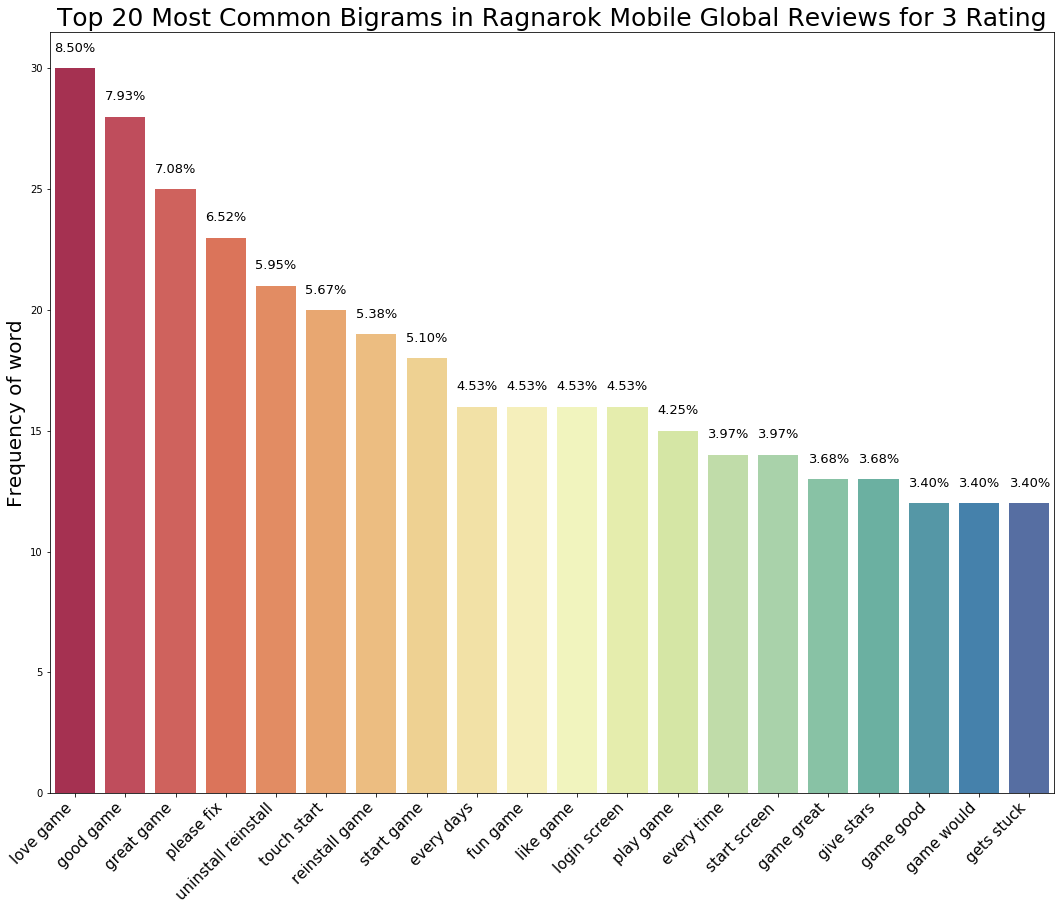

In [102]:
mostcommonwords203biglobal = bigram3global[:20]

yaxis203biglobal = [val[1] for val in mostcommonwords203biglobal]

xaxis203biglobal = [val[0] for val in mostcommonwords203biglobal]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis203biglobal, yaxis203biglobal, palette ="Spectral")
plt.title('Top 20 Most Common Bigrams in Ragnarok Mobile Global Reviews for 3 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis203biglobal))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [ ]:
# Returns nothing.

#trigram3global = n_gramall(rating3global['content'], n=3)
#trigram3global[:20]

---------

In [103]:
# Rating 4

bigram4global = n_gramall(rating4global['content'], n=2)
bigram4global[:20]

[('great game', 52),
 ('good game', 39),
 ('love game', 26),
 ('fun game', 24),
 ('ragnarok online', 23),
 ('please fix', 18),
 ('pretty good', 16),
 ('play game', 13),
 ('start screen', 13),
 ('game great', 12),
 ('game play', 12),
 ('pretty fun', 12),
 ('get past', 11),
 ('touch start', 11),
 ('pc version', 10)]

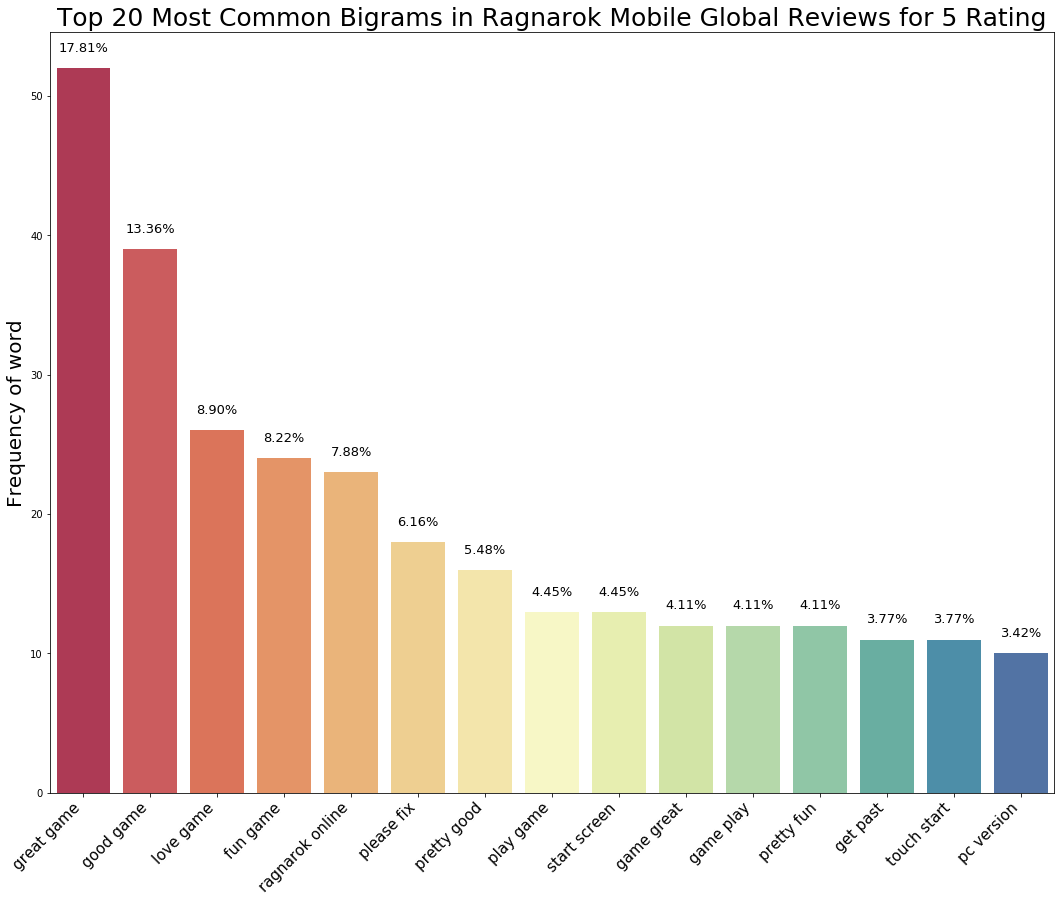

In [104]:
mostcommonwords204biglobal = bigram4global[:20]

yaxis204biglobal = [val[1] for val in mostcommonwords204biglobal]

xaxis204biglobal = [val[0] for val in mostcommonwords204biglobal]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis204biglobal, yaxis204biglobal, palette ="Spectral")
plt.title('Top 20 Most Common Bigrams in Ragnarok Mobile Global Reviews for 5 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis204biglobal))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [ ]:
# Returns nothing.

#trigram4global = n_gramall(rating4global['content'], n=3)
#trigram4global[:20]

------

In [105]:
# Rating 5

bigram5global = n_gramall(rating5global['content'], n=2)
bigram5global[:20]

[('great game', 169),
 ('love game', 119),
 ('brings back', 87),
 ('good game', 80),
 ('ragnarok online', 60),
 ('best game', 59),
 ('fun game', 57),
 ('amazing game', 50),
 ('awesome game', 50),
 ('mobile game', 48),
 ('game ever', 42),
 ('nice game', 41),
 ('original ro', 33),
 ('back memories', 32),
 ('pc version', 32),
 ('game play', 31),
 ('original ragnarok', 30),
 ('years ago', 30),
 ('game love', 29),
 ('really fun', 29)]

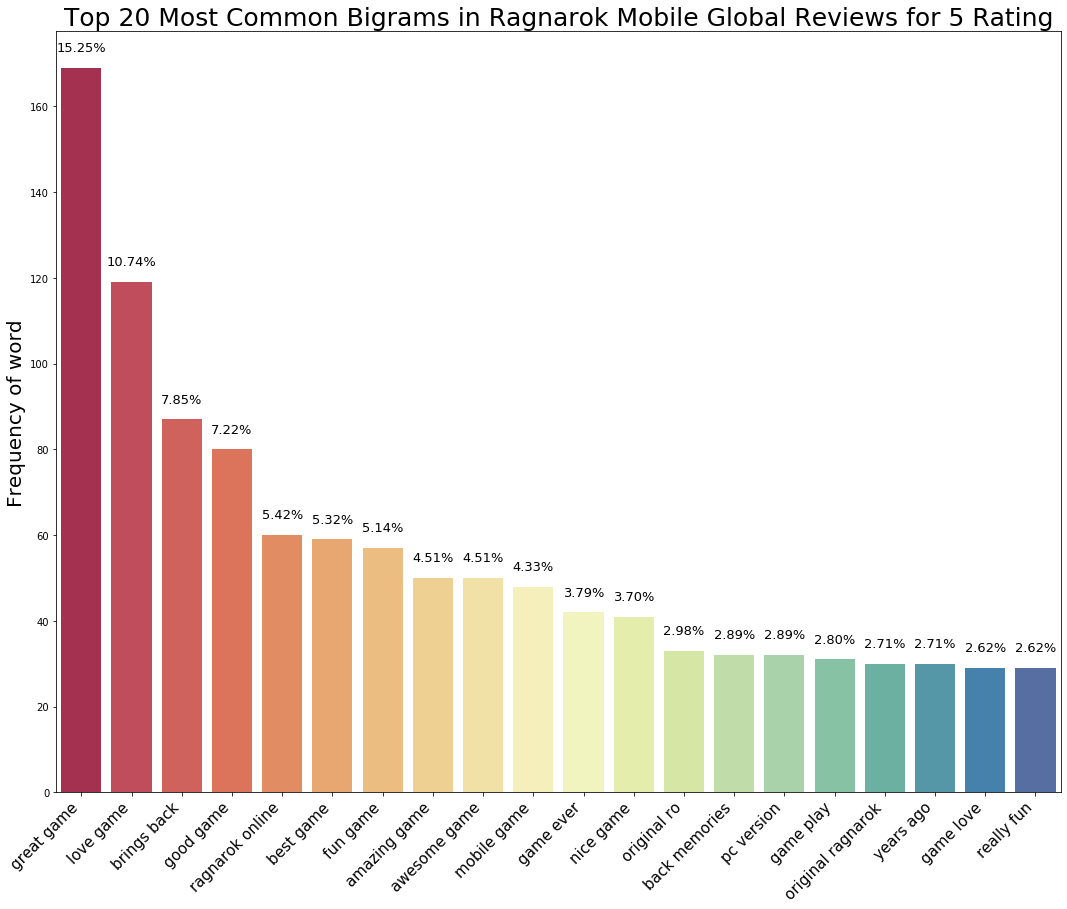

In [106]:
mostcommonwords205biglobal = bigram5global[:20]

yaxis205biglobal = [val[1] for val in mostcommonwords205biglobal]

xaxis205biglobal = [val[0] for val in mostcommonwords205biglobal]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis205biglobal, yaxis205biglobal, palette ="Spectral")
plt.title('Top 20 Most Common Bigrams in Ragnarok Mobile Global Reviews for 5 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis205biglobal))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [107]:
trigram5global = n_gramall(rating5global['content'], n=3)
trigram5global[:20]

[('best game ever', 33),
 ('brings back memories', 27),
 ('game brings back', 19),
 ('brings back many', 11),
 ('brings back old', 10),
 ('original ragnarok online', 10)]

# Bigrams/Trigrams for specific ratings for ROM SEA

In [108]:
# Rating 1

bigram1sea = n_gramall(rating1sea['content'], n=2)
bigram1sea[:20]

[('pay win', 905),
 ('3rd party', 850),
 ('many bugs', 816),
 ('please fix', 782),
 ('play game', 742),
 ('add ons', 670),
 ('woe woc', 481),
 ('black screen', 476),
 ('15 days', 461),
 ('ban cheaters', 436),
 ('full bugs', 410),
 ('permanent ban', 408),
 ('love game', 398),
 ('perma ban', 391),
 ('fix bugs', 365),
 ('waste time', 348),
 ('good game', 338),
 ('money game', 328),
 ('many bug', 317),
 ('playing game', 306)]

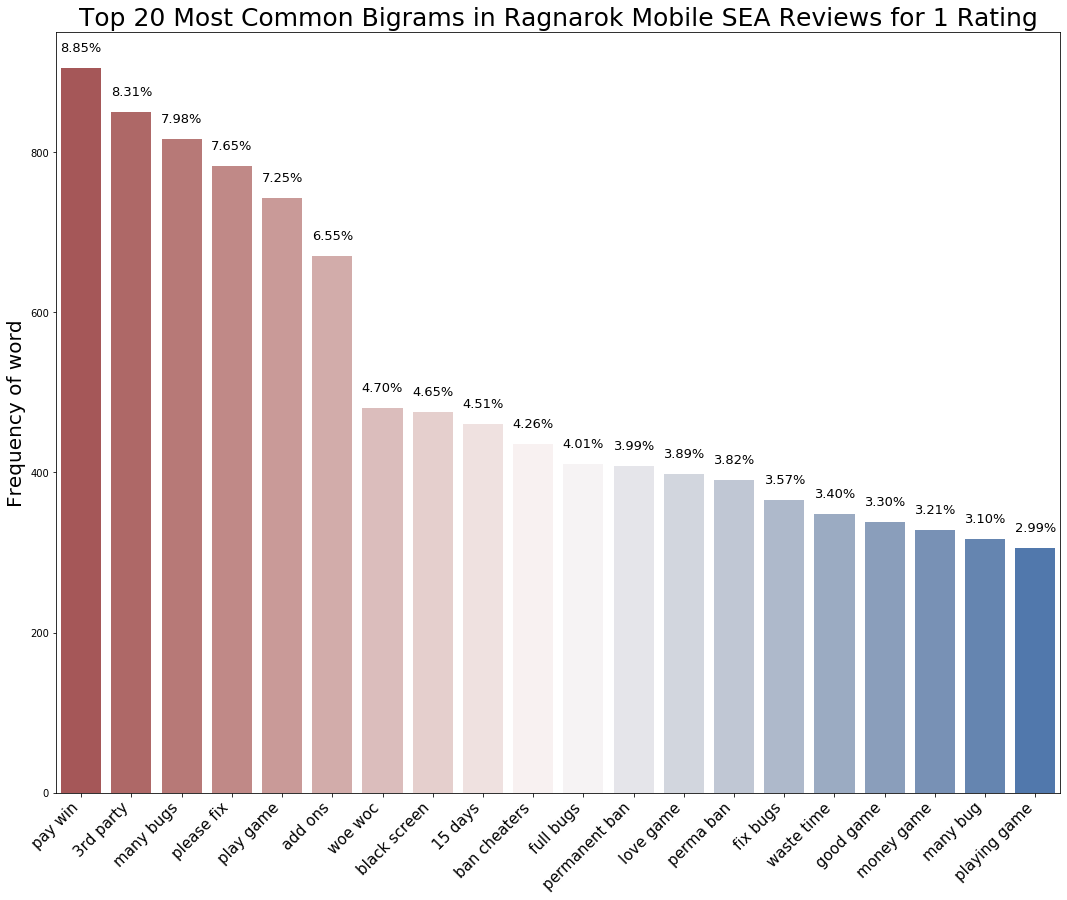

In [109]:
mostcommonwords201bisea = bigram1sea[:20]

yaxis201bisea = [val[1] for val in mostcommonwords201bisea]

xaxis201bisea = [val[0] for val in mostcommonwords201bisea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis201bisea, yaxis201bisea, palette ="vlag_r")
plt.title('Top 20 Most Common Bigrams in Ragnarok Mobile SEA Reviews for 1 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis201bisea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [114]:
trigram1sea = n_gramall(rating1sea['content'], n=3)
trigram1sea[:20]

[('pay win game', 218),
 ('3rd party app', 176),
 ('stuck loading screen', 162),
 ('using 3rd party', 150),
 ('lagnarok eternal bug', 141),
 ('3rd party program', 135),
 ('15 days ban', 115),
 ('3rd party apps', 114),
 ('bugnarok eternal lag', 105),
 ('game full bugs', 105),
 ('perma ban cheaters', 99),
 ('ban add users', 95),
 ('15 days suspension', 87),
 ('waste time money', 82),
 ('permanent ban cheaters', 81),
 ('use 3rd party', 81),
 ('dont play game', 80),
 ('bug bug bug', 79),
 ('using add ons', 76),
 ('game pay win', 72)]

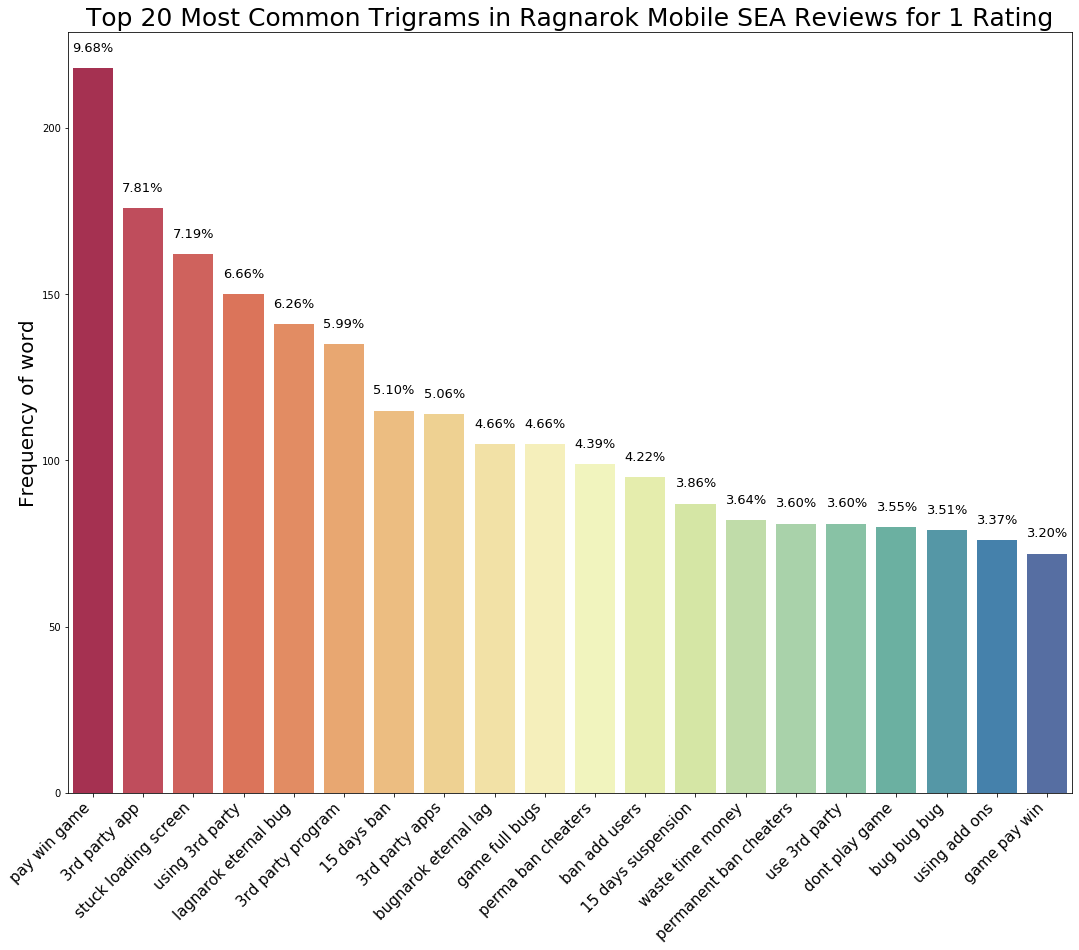

In [115]:
mostcommonwords201trisea = trigram1sea[:20]

yaxis201trisea = [val[1] for val in mostcommonwords201trisea]

xaxis201trisea = [val[0] for val in mostcommonwords201trisea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis201trisea, yaxis201trisea, palette ="Spectral")
plt.title('Top 20 Most Common Trigrams in Ragnarok Mobile SEA Reviews for 1 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis201trisea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [112]:
# Rating 2

bigram2sea = n_gramall(rating2sea['content'], n=2)
bigram2sea[:20]

[('please fix', 228),
 ('play game', 94),
 ('loading screen', 91),
 ('black screen', 88),
 ('stuck loading', 82),
 ('pay win', 55),
 ('love game', 53),
 ('good game', 51),
 ('cant login', 49),
 ('please help', 47),
 ('great game', 44),
 ('pls fix', 44),
 ('cant play', 42),
 ('game good', 42),
 ('many bugs', 38),
 ('cant log', 36),
 ('fix problem', 34),
 ('playing game', 34),
 ('start game', 33),
 ('cant download', 30)]

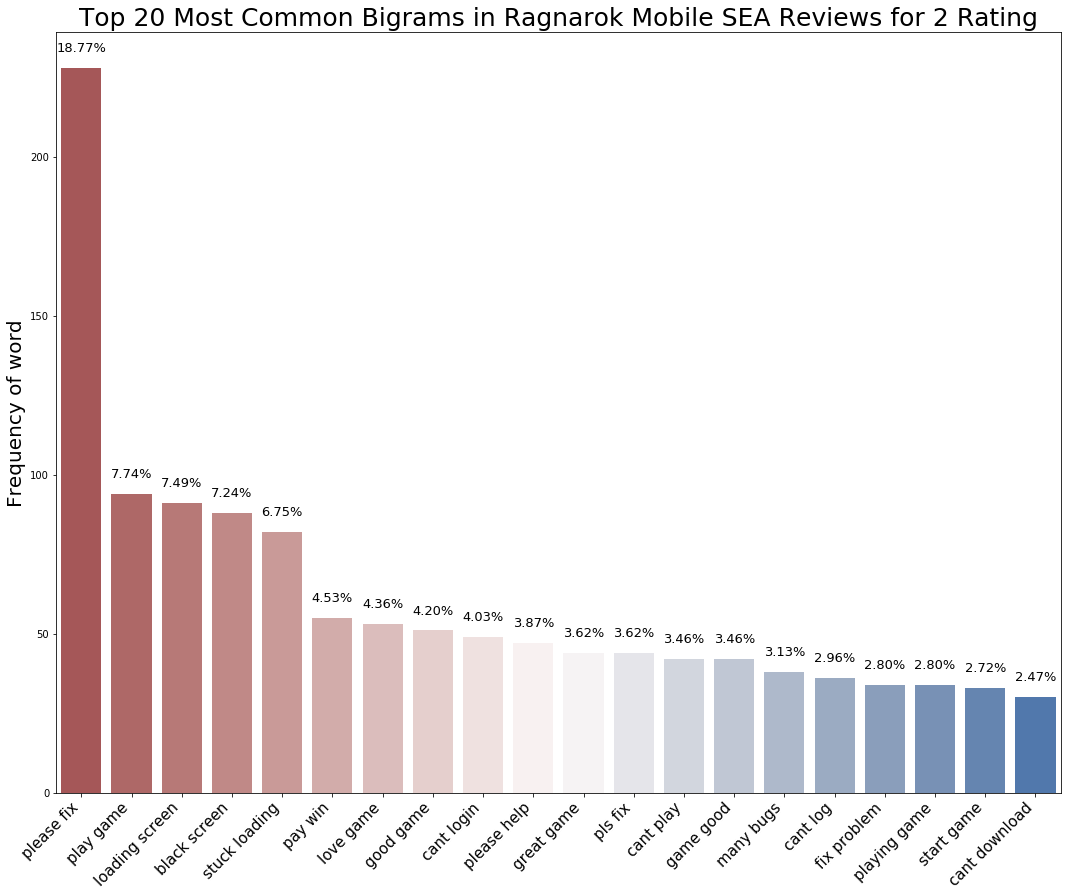

In [113]:
mostcommonwords202bisea = bigram2sea[:20]

yaxis202bisea = [val[1] for val in mostcommonwords202bisea]

xaxis202bisea = [val[0] for val in mostcommonwords202bisea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis202bisea, yaxis202bisea, palette ="vlag_r")
plt.title('Top 20 Most Common Bigrams in Ragnarok Mobile SEA Reviews for 2 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis202bisea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [119]:
trigram2sea = n_gramall(rating2sea['content'], n=3)
trigram2sea[:20]

[('stuck loading screen', 54),
 ('please fix bug', 16),
 ('please fix problem', 14),
 ('stuck login screen', 14),
 ('cant login game', 13),
 ('stuck black screen', 11),
 ('im stuck loading', 10)]

In [117]:
# Rating 3

bigram3sea = n_gramall(rating3sea['content'], n=2)
bigram3sea[:20]

[('please fix', 298),
 ('loading screen', 140),
 ('good game', 125),
 ('stuck loading', 125),
 ('play game', 113),
 ('love game', 100),
 ('please help', 98),
 ('black screen', 85),
 ('cant log', 75),
 ('game good', 68),
 ('great game', 60),
 ('cant login', 58),
 ('pls fix', 53),
 ('nice game', 49),
 ('enter game', 48),
 ('fix bug', 48),
 ('many bugs', 46),
 ('start game', 46),
 ('pay win', 45),
 ('im using', 44)]

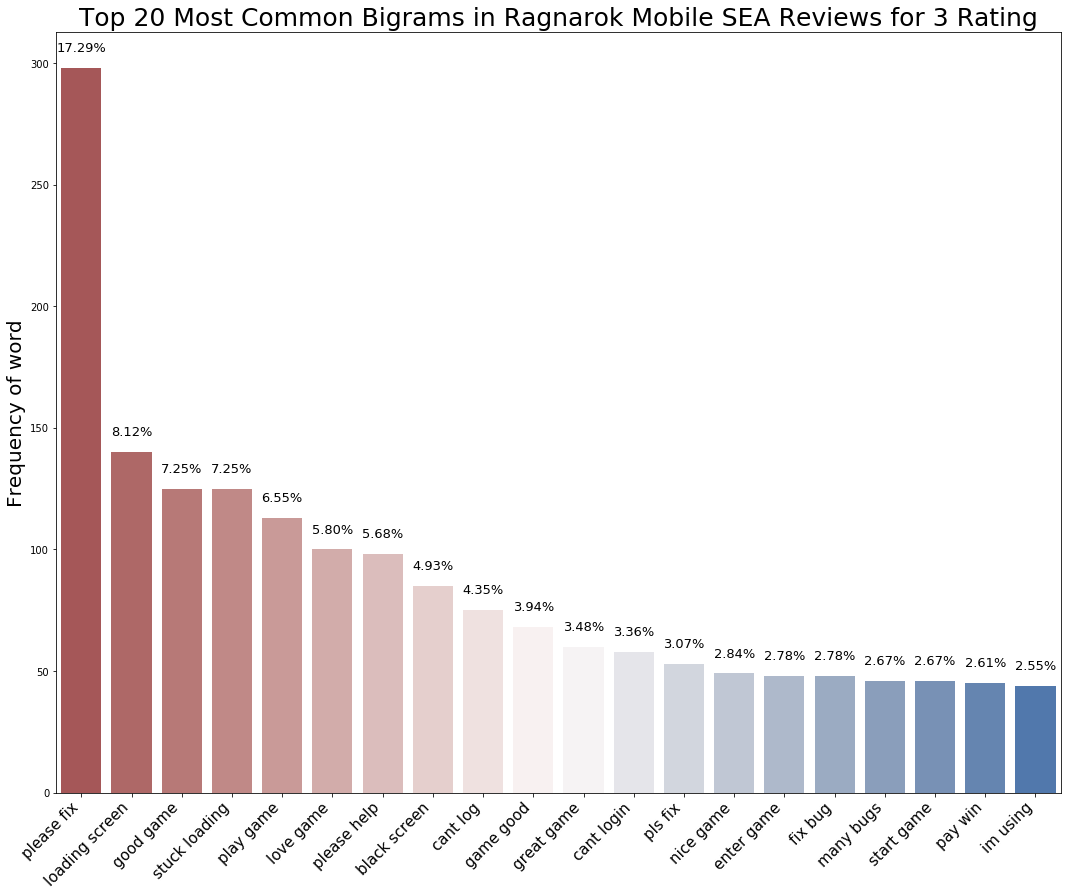

In [118]:
mostcommonwords203bisea = bigram3sea[:20]

yaxis203bisea = [val[1] for val in mostcommonwords203bisea]

xaxis203bisea = [val[0] for val in mostcommonwords203bisea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis203bisea, yaxis203bisea, palette ="vlag_r")
plt.title('Top 20 Most Common Bigrams in Ragnarok Mobile SEA Reviews for 3 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis203bisea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [120]:
trigram3sea = n_gramall(rating3sea['content'], n=3)
trigram3sea[:20]

[('stuck loading screen', 82),
 ('please fix bug', 22),
 ('game please fix', 19),
 ('please fix asap', 19),
 ('big cat coin', 17),
 ('please fix thanks', 17),
 ('game stuck loading', 16),
 ('stuck loading page', 16),
 ('cant enter game', 15),
 ('cant play game', 15),
 ('screen please fix', 14),
 ('always stuck loading', 13),
 ('want play game', 13),
 ('stuck login screen', 12),
 ('touch start game', 12),
 ('cant login game', 11),
 ('please fix issue', 11),
 ('please help fix', 11),
 ('really love game', 11),
 ('im stuck loading', 10)]

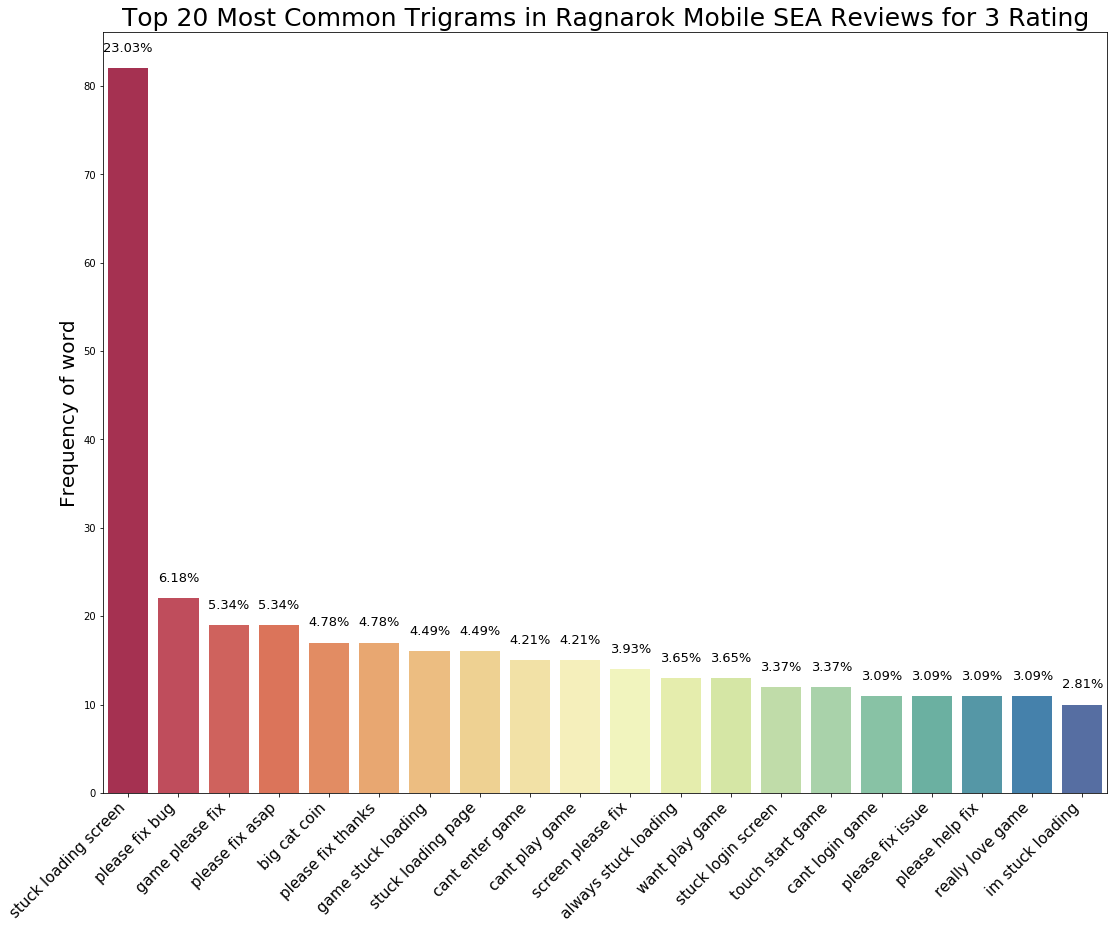

In [121]:
mostcommonwords203trisea = trigram3sea[:20]

yaxis203trisea = [val[1] for val in mostcommonwords203trisea]

xaxis203trisea = [val[0] for val in mostcommonwords203trisea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis203trisea, yaxis203trisea, palette ="Spectral")
plt.title('Top 20 Most Common Trigrams in Ragnarok Mobile SEA Reviews for 3 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis203trisea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [122]:
# Rating 4

bigram4sea = n_gramall(rating4sea['content'], n=2)
bigram4sea[:20]

[('good game', 254),
 ('please fix', 202),
 ('nice game', 180),
 ('great game', 171),
 ('love game', 124),
 ('play game', 83),
 ('loading screen', 76),
 ('game good', 71),
 ('stuck loading', 71),
 ('please help', 64),
 ('far good', 49),
 ('fix bugs', 49),
 ('like game', 49),
 ('brings back', 47),
 ('good job', 43),
 ('game great', 40),
 ('pls fix', 40),
 ('cant play', 39),
 ('black screen', 38),
 ('cant login', 38)]

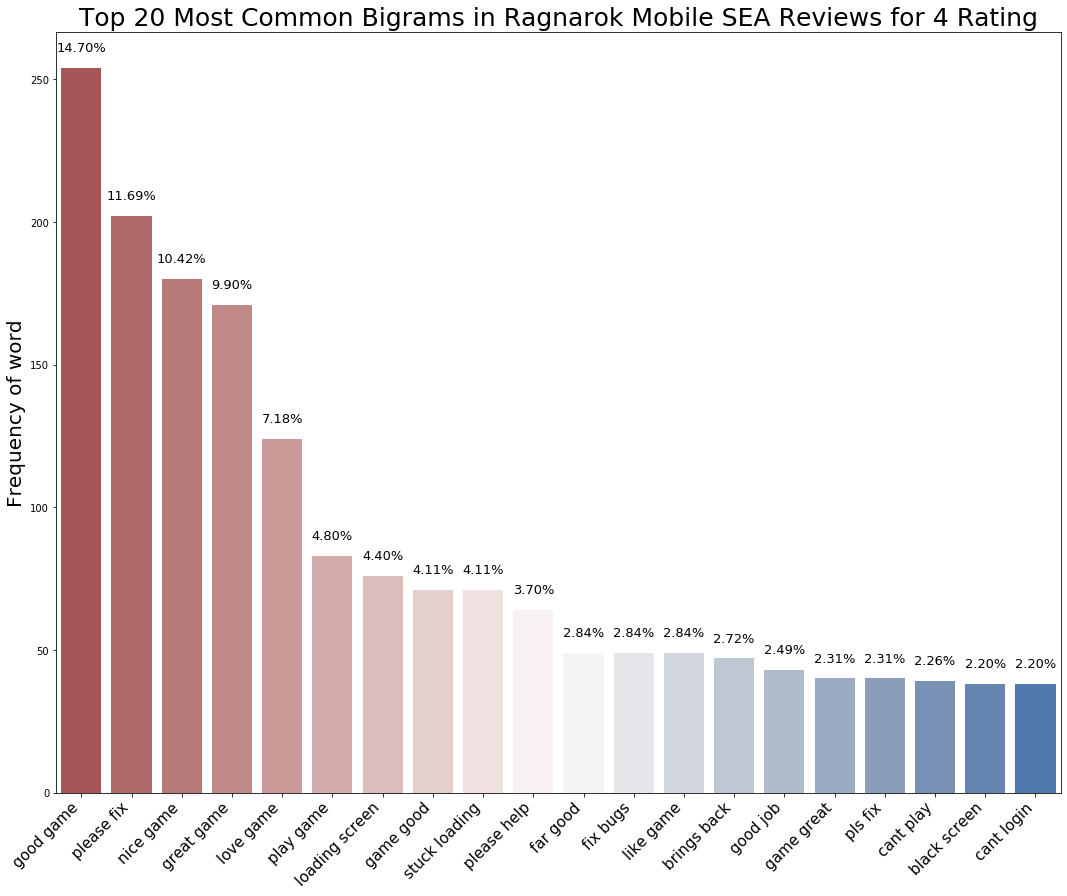

In [123]:
mostcommonwords204bisea = bigram4sea[:20]

yaxis204bisea = [val[1] for val in mostcommonwords204bisea]

xaxis204bisea = [val[0] for val in mostcommonwords204bisea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis204bisea, yaxis204bisea, palette ="vlag_r")
plt.title('Top 20 Most Common Bigrams in Ragnarok Mobile SEA Reviews for 4 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis204bisea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [124]:
trigram4sea = n_gramall(rating4sea['content'], n=3)
trigram4sea[:20]

[('stuck loading screen', 52),
 ('keep good work', 25),
 ('brings back memories', 23),
 ('please fix bug', 16),
 ('game brings back', 15),
 ('please fix bugs', 15),
 ('best game ever', 14),
 ('love game much', 13),
 ('really love game', 13),
 ('game please fix', 10),
 ('pay win game', 10),
 ('screen please fix', 10)]

In [125]:
# Rating 5

bigram5sea = n_gramall(rating5sea['content'], n=2)
bigram5sea[:20]

[('nice game', 1851),
 ('good game', 1629),
 ('great game', 1196),
 ('love game', 992),
 ('best game', 800),
 ('game ever', 652),
 ('brings back', 366),
 ('bring back', 302),
 ('good job', 291),
 ('please fix', 285),
 ('play game', 280),
 ('back memories', 278),
 ('awesome game', 271),
 ('best mmorpg', 257),
 ('game good', 194),
 ('back old', 188),
 ('game love', 176),
 ('like game', 175),
 ('playing game', 148),
 ('keep good', 146)]

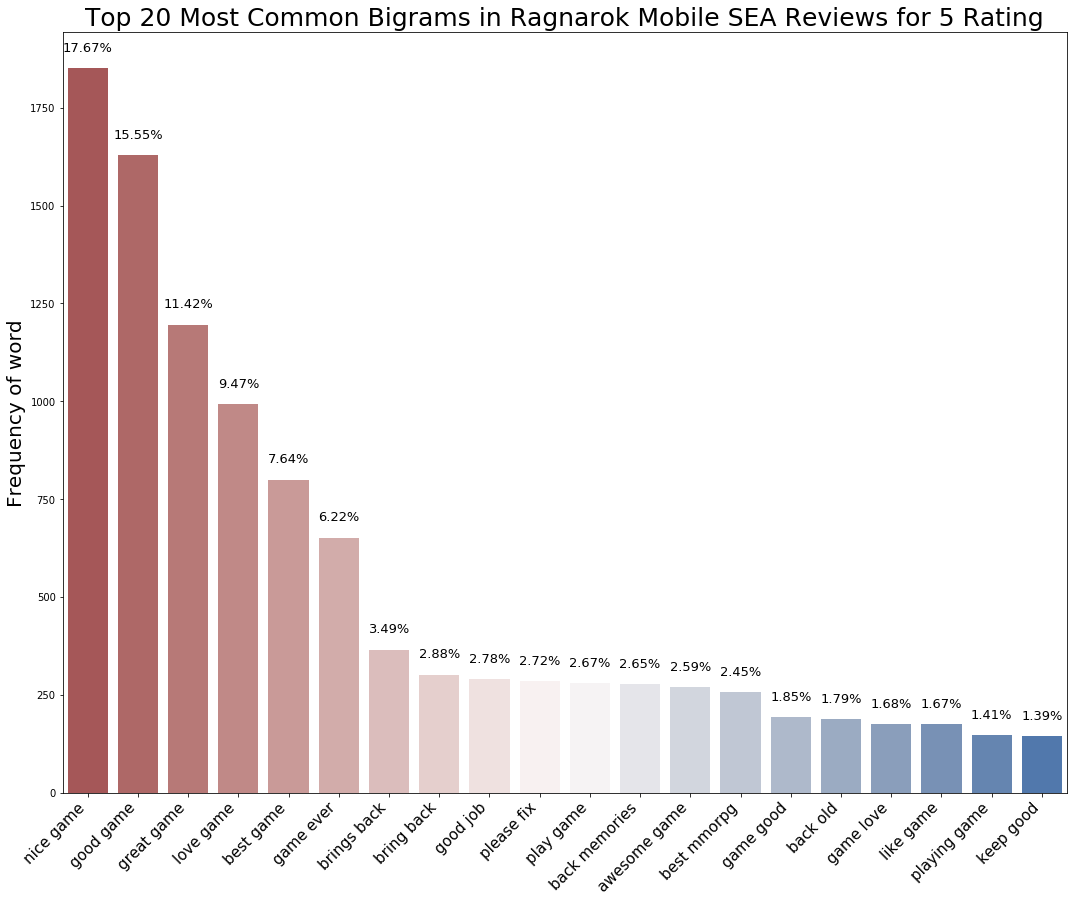

In [126]:
mostcommonwords205bisea = bigram5sea[:20]

yaxis205bisea = [val[1] for val in mostcommonwords205bisea]

xaxis205bisea = [val[0] for val in mostcommonwords205bisea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis205bisea, yaxis205bisea, palette ="vlag_r")
plt.title('Top 20 Most Common Bigrams in Ragnarok Mobile SEA Reviews for 5 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis205bisea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [127]:
trigram5sea = n_gramall(rating5sea['content'], n=3)
trigram5sea[:20]

[('best game ever', 412),
 ('brings back memories', 155),
 ('keep good work', 128),
 ('bring back memories', 104),
 ('love game much', 80),
 ('bring back old', 77),
 ('game brings back', 77),
 ('back old memories', 76),
 ('really love game', 76),
 ('brings back old', 60),
 ('game bring back', 56),
 ('stuck loading screen', 49),
 ('good old days', 47),
 ('best mobile game', 46),
 ('game ever played', 43),
 ('brings back childhood', 41),
 ('best mmorpg mobile', 38),
 ('like old times', 38),
 ('nice game love', 37),
 ('best mmorpg ever', 36)]

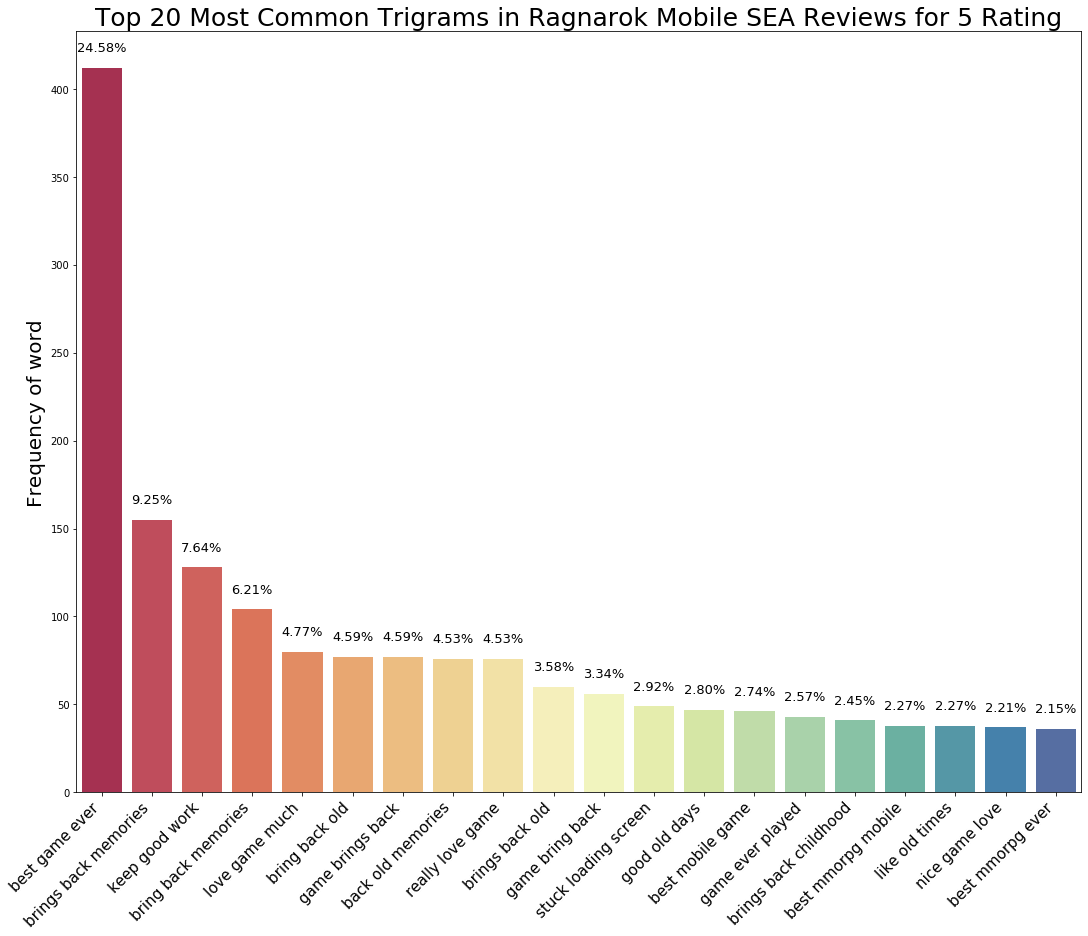

In [128]:
mostcommonwords205trisea = trigram5sea[:20]

yaxis205trisea = [val[1] for val in mostcommonwords205trisea]

xaxis205trisea = [val[0] for val in mostcommonwords205trisea]

plt.figure(figsize=(18, 14))
ax = sns.barplot(xaxis205trisea, yaxis205trisea, palette ="Spectral")
plt.title('Top 20 Most Common Trigrams in Ragnarok Mobile SEA Reviews for 5 Rating', fontsize = 25)
plt.ylabel('Frequency of word', fontsize = 20)
plt.xticks(rotation=45, fontsize = 15, ha='right')


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/sum(yaxis205trisea))+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 20),
                 textcoords='offset points')